<a name='top'></a>
Javier Lopez<br>
Student ID: 000697446
# Model NYC Rideshare, Weather, Covid, and Vaccination Data
## Feb 2019-Mar 2022
***

>**Research Question 3:**
>
>Which predictive model and exogenous variables have the most impact on rideshare demand and forecasting?
***

In [1]:
import warnings
import calendar as cal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from  sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.weightstats import ztest
from pmdarima.arima import auto_arima
from prophet import Prophet
from prophet.plot import plot_weekly
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import chisquare
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
plt.style.use('seaborn-whitegrid')
pd.set_option('mode.chained_assignment', None)
np.seterr(divide = 'ignore') 
warnings.filterwarnings('ignore')

## Load Data
***

In [2]:
data = pd.read_parquet('data/clean_data/model_dataset.parquet')

In [3]:
data.nyc.head(3)

uber      lyft  temp  prec  snow  case  hospitalized  death  \
2019-02-01  571535.0  197336.0  16.0   0.0   0.0   0.0           0.0    0.0   
2019-02-02  594632.0  193081.0  25.0   0.0   0.0   0.0           0.0    0.0   
2019-02-03  510417.0  174515.0  43.0   0.0   0.0   0.0           0.0    0.0   

            vaccination  phase_0  phase_1  phase_2  phase_3  
2019-02-01          0.0      1.0      0.0      0.0      0.0  
2019-02-02          0.0      1.0      0.0      0.0      0.0  
2019-02-03          0.0      1.0      0.0      0.0      0.0

In [4]:
lyft = data.nyc[['lyft']]
lyft.name = 'lyft'
weather = data.nyc[['temp', 'prec']]
covid = data.nyc[['case', 'hospitalized', 'death']]
vax = data.nyc[['vaccination']]

***
## Model Endogenous Variable: Rideshare Data <a name='0'/> 
***

### Data Preprocessing: Split Train/Test
***

In [5]:
def get_Xy_features(df):
    y = df.copy()
    X = pd.DataFrame(index=df.index)
    X['dayofweek'] = X.index.dayofweek
    X['quarter'] = X.index.quarter
    X['month'] = X.index.month
    X['year'] = X.index.year
    X['dayofyear'] = X.index.dayofyear
    X['dayofmonth'] = X.index.day
    X['weekofyear'] = X.index.weekofyear
    X[['phase_0', 'phase_1', 'phase_2', 'phase_3']] = data.nyc[['phase_0', 'phase_1', 'phase_2', 'phase_3']]
    
    holidays = ['2019/02/18', '2019/05/27', '2019/07/04', '2019/09/02', '2019/10/14', '2019/11/11', '2019/11/28', 
                '2019/12/25', '2020/01/01', '2020/01/20', '2020/02/17', '2020/05/25', '2020/07/03', '2020/07/04', 
                '2020/09/07', '2020/10/12', '2020/11/11', '2020/11/26', '2020/12/25', '2021/01/01', '2021/01/18', 
                '2021/02/15', '2021/05/31', '2021/06/18', '2021/06/19', '2021/07/04', '2021/07/05', '2021/09/06', 
                '2021/10/11', '2021/11/11', '2021/11/25', '2021/12/24', '2021/12/25', '2021/12/31', '2022/01/01',
                '2022/01/17', '2022/02/21']
    
    holiday = []
    for x in range(len(X)):
        if X.iloc[x].index.values[0] in holidays:
            holiday.append(1)
        else:
            holiday.append(0)
    X['holiday'] = holiday
        
    return X, y

In [6]:
X, y = get_Xy_features(lyft)

In [7]:
X.head(3)

dayofweek  quarter  month  year  dayofyear  dayofmonth  \
2019-02-01          4        1      2  2019         32           1   
2019-02-02          5        1      2  2019         33           2   
2019-02-03          6        1      2  2019         34           3   

            weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
2019-02-01           5      1.0      0.0      0.0      0.0        0  
2019-02-02           5      1.0      0.0      0.0      0.0        0  
2019-02-03           5      1.0      0.0      0.0      0.0        0

In [8]:
y.head(3)

lyft
2019-02-01  197336.0
2019-02-02  193081.0
2019-02-03  174515.0

In [9]:
chisquare(y[:'2021/04/30'])

Power_divergenceResult(statistic=array([13693738.67948112]), pvalue=array([0.]))

In [10]:
chisquare(y['2021/05/01':])

Power_divergenceResult(statistic=array([1446830.07885074]), pvalue=array([0.]))

In [11]:
def split_train_test(df, train_stop, test_start):
    train = df[:train_stop]
    test = df[test_start:]
    return train, test

In [12]:
train_stop = '2021/04/30'
test_start = '2021/05/01'

In [13]:
X_train, X_test = split_train_test(X, train_stop, test_start)
y_train, y_test = split_train_test(y, train_stop, test_start)

In [14]:
print('Train: %s observations from %s to %s' 
      %(len(y_train), 
        y_train.iloc[0].name.strftime('%m/%d/%Y'), 
        y_train.iloc[-1].name.strftime('%m/%d/%Y')))
print('Test: %s observation from %s to %s' 
      %(len(y_test), 
        y_test.iloc[0].name.strftime('%m/%d/%Y'), 
        y_test.iloc[-1].name.strftime('%m/%d/%Y')))

Train: 820 observations from 02/01/2019 to 04/30/2021
Test: 335 observation from 05/01/2021 to 03/31/2022


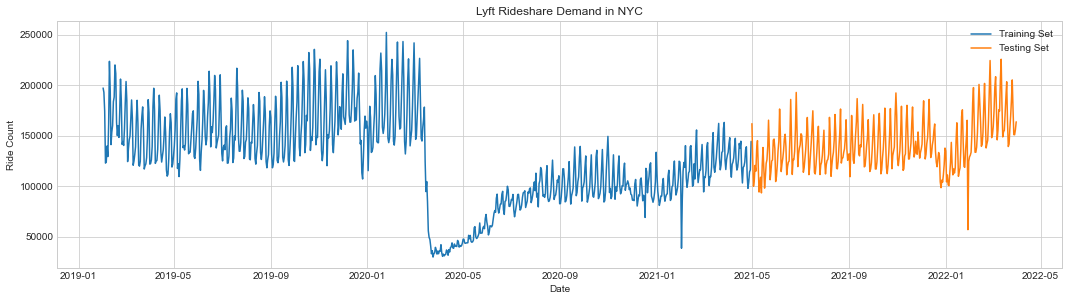

In [15]:
plt.subplot(211)
sns.lineplot(data=y_train.lyft, label='Training Set')
sns.lineplot(data=y_test.lyft, label= 'Testing Set')
plt.title('Lyft Rideshare Demand in NYC')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.show()

### Track Model Performance
***

In [16]:
def get_metrics(results, metrics, algo, name):
    expected = results.expected
    predicted = results.predicted
    metrics.loc[algo, name].rmse = np.round(skm.mean_squared_error(expected, predicted, squared=False), 2)
    metrics.loc[algo, name].mape = np.round(skm.mean_absolute_percentage_error(expected, predicted)*100, 2)
    metrics.loc[algo, name].z_score = np.round(ztest(expected, predicted)[0], 3)
    metrics.loc[algo, name].pvalue = ztest(expected, predicted)[1]
    metrics.loc[algo, name].observed_mean = np.round(expected.mean(), 2)
    metrics.loc[algo, name].forecast_mean = np.round(predicted.mean(), 2)
    metrics.loc[algo, name].observed_std = np.round(np.std(expected), 2)
    metrics.loc[algo, name].forecast_std = np.round(np.std(predicted), 2)
    return metrics

In [17]:
iterables = [['sarimax', 'prophet', 'xgboost'], 
             ['control', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']]
index = pd.MultiIndex.from_product(iterables)
metrics = pd.DataFrame(index=index, 
                       columns=['rmse', 'mape', 'z_score', 'pvalue', 'observed_mean', 'forecast_mean', 'observed_std',
                                'forecast_std'])

In [18]:
metrics.head(3)

rmse mape z_score pvalue observed_mean forecast_mean  \
sarimax control  NaN  NaN     NaN    NaN           NaN           NaN   
        model_1  NaN  NaN     NaN    NaN           NaN           NaN   
        model_2  NaN  NaN     NaN    NaN           NaN           NaN   

                observed_std forecast_std  
sarimax control          NaN          NaN  
        model_1          NaN          NaN  
        model_2          NaN          NaN

### SARIMAX
***

#### Get Model Parameters
***

In [19]:
sarimax = auto_arima(y_train, exog=X_train, seasonal=True, m=7, trace=False, stepwise=True)

In [20]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -8814.651
Date:                             Thu, 11 Aug 2022   AIC                          17643.303
Time:                                     19:19:30   BIC                          17676.259
Sample:                                          0   HQIC                         17655.949
                                             - 820                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1264      0.067     16.928      0.000       0.996       1.257
ar.L2         -0.6842      0.040    -17.172      0.000      -0.762      -0.606
ma.L1         -1.3194      0.071    -18.485      0.000      -1.459      -1.180
ma.L2          0.6493      0.058     11.251      0.000       0.536       0.762
ar.S.L7        0.9710      0.007    132.959      0.000       0.957       0.985
ma.S.L7       -0.8358      0.023    -36.174      0.000      -0.881      -0.791
sigma2      1.641e+08   2.57e-10   6.38e+17      0.000    1.64e+08    1.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               929.66
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.72
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.1e+32. Standard errors may be unstable.
"""

#### Train Model
***

In [21]:
mod = SARIMAX(y_train, exog=X_train, order=sarimax.order, seasonal_order=sarimax.seasonal_order, m=7).fit(disp=False)

In [22]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9241.116
Date:                             Thu, 11 Aug 2022   AIC                          18520.231
Time:                                     19:19:31   BIC                          18609.685
Sample:                                 02-01-2019   HQIC                         18554.557
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   4896.7283    207.815     23.563      0.000    4489.419    5304.038
quarter    -7069.4108      9.417   -750.691      0.000   -7087.868   -7050.953
month      -2.173e+04      2.784  -7806.518      0.000   -2.17e+04   -2.17e+04
year       -1.667e+04      0.789  -2.11e+04      0.000   -1.67e+04   -1.67e+04
dayofyear    780.5058     44.997     17.346      0.000     692.313     868.699
dayofmonth  -739.8449     66.434    -11.137      0.000    -870.053    -609.637
weekofyear  -386.1812   1078.813     -0.358      0.720   -2500.615    1728.253
phase_0    -2472.9161      0.008  -3.04e+05      0.000   -2472.932   -2472.900
phase_1     5994.6946      0.008   7.51e+05      0.000    5994.679    5994.710
phase_2     2902.3054      0.004   8.06e+05      0.000    2902.298    2902.312
phase_3    -6424.0839      0.001  -4.36e+06      0.000   -6424.087   -6424.081
holiday             0     67.230          0      1.000    -131.769     131.769
ar.L1      -3.571e-05      0.818  -4.37e-05      1.000      -1.602       1.602
ar.L2          0.0015      1.956      0.001      0.999      -3.833       3.835
ma.L1         -0.0002      0.817     -0.000      1.000      -1.601       1.601
ma.L2         -0.0022      1.956     -0.001      0.999      -3.837       3.832
ar.S.L7        0.8842      0.036     24.698      0.000       0.814       0.954
ma.S.L7       -0.8831      0.036    -24.602      0.000      -0.953      -0.813
sigma2      1.786e+08      0.015   1.19e+10      0.000    1.79e+08    1.79e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):                 7.61
Prob(Q):                              0.19   Prob(JB):                         0.02
Heteroskedasticity (H):               0.76   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.24e+27. Standard errors may be unstable.
"""

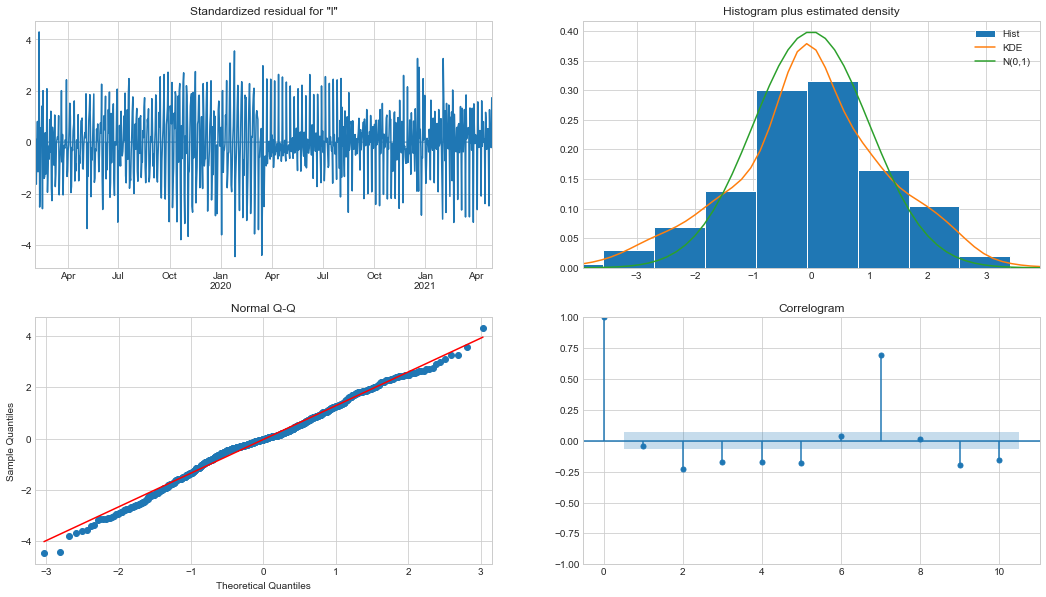

In [23]:
fig = mod.plot_diagnostics()

#### Test Model
***

In [24]:
fcast = mod.get_forecast(exog=X_test, steps=len(y_test)).summary_frame()

In [25]:
fcast.head(3)

lyft                 mean       mean_se  mean_ci_lower  mean_ci_upper
2021-05-01  149871.389357  13364.546167  123677.360199  176065.418514
2021-05-02  154479.567070  18897.630288  117440.892312  191518.241829
2021-05-03  124917.348482  23137.944134   79567.811303  170266.885662

In [26]:
sarimax_results = pd.concat([y_test, fcast], axis=1).dropna()
sarimax_results.mean_se = y_test.lyft - sarimax_results['mean']
sarimax_res_cols = ['expected','predicted','error','lower','upper']
sarimax_results.columns = sarimax_res_cols

#### Plot Results
***

In [27]:
sarimax_results.head(3)

expected      predicted         error          lower  \
2021-05-01  162024.0  149871.389357  12152.610643  123677.360199   
2021-05-02  125580.0  154479.567070 -28899.567070  117440.892312   
2021-05-03   99954.0  124917.348482 -24963.348482   79567.811303   

                    upper  
2021-05-01  176065.418514  
2021-05-02  191518.241829  
2021-05-03  170266.885662

In [28]:
def plot_results(results, model_name, train):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(results[['expected','predicted']], label=['Expected','Predicted'])
    if 'lower' in results.columns and 'upper' in results.columns:
        ax[0].fill_between(results.index, results['lower'], results['upper'], 
                             color='k', alpha=0.1, label='Upper/Lower')
    ax[0].set_title('%s Predicted vs Expected - Jan-Mar 2022' %model_name)
    ax[0].set_ylabel('Ride Count')
    ax[0].grid(alpha=0.25)
    ax[0].legend()

    ax[1].plot(train, label='Training')
    ax[1].plot(results[['expected','predicted']], label=['Expected','Predicted'])
    if 'lower' in results.columns and 'upper' in results.columns:
        ax[1].fill_between(results.index, results['lower'], results['upper'], 
                             color='k', alpha=0.1, label='Upper/Lower')
    ax[1].set_title('%s Train, Test, Predict - Apr 2020-Mar 2022' %model_name)
    ax[1].set_ylabel('Ride Count')
    ax[1].grid(alpha=0.25)
    ax[1].legend()

    ax[2].plot(results.error)
    ax[2].set_title('Error')
    ax[2].set_xlabel('Date')
    ax[2].set_ylabel('Error')
    ax[2].grid(alpha=0.25)
    plt.tight_layout()

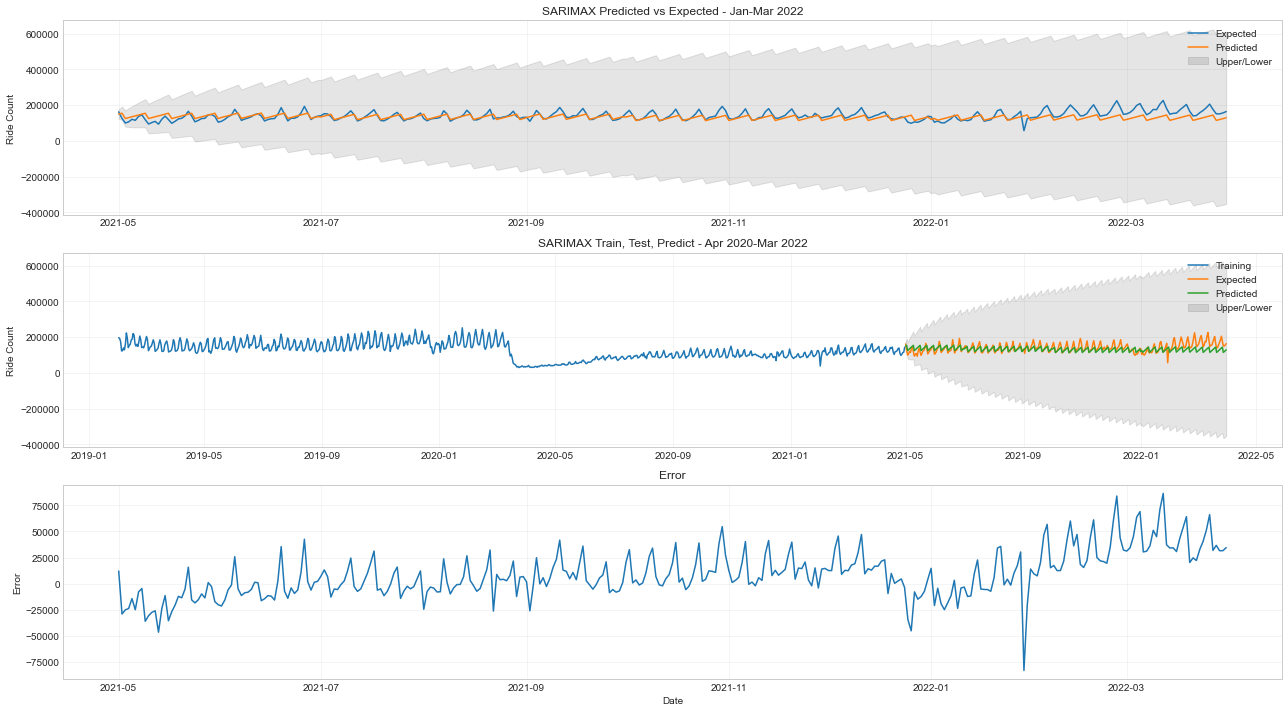

In [29]:
plot_results(sarimax_results, 'SARIMAX', y_train)

In [30]:
get_metrics(sarimax_results, metrics, 'sarimax', 'control').dropna()

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  23910.85  11.99   5.948    0.0     141329.33     132563.03   

                observed_std forecast_std  
sarimax control      24706.0     10727.75

### Prophet <a name='16'/>
***

In [31]:
prophet_train = y_train.reset_index()
prophet_train.columns = ['ds', 'y']
prophet_train = pd.concat([prophet_train, X_train.reset_index(drop=True)], axis=1)
prophet_train.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2019-02-01  197336.0          4        1      2  2019         32   
1 2019-02-02  193081.0          5        1      2  2019         33   
2 2019-02-03  174515.0          6        1      2  2019         34   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           1           5      1.0      0.0      0.0      0.0        0  
1           2           5      1.0      0.0      0.0      0.0        0  
2           3           5      1.0      0.0      0.0      0.0        0

In [32]:
prophet_test = y_test.reset_index()
prophet_test.columns = ['ds', 'y']
prophet_test = pd.concat([prophet_test, X_test.copy().reset_index(drop=True)], axis=1)
prophet_test.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2021-05-01  162024.0          5        2      5  2021        121   
1 2021-05-02  125580.0          6        2      5  2021        122   
2 2021-05-03   99954.0          0        2      5  2021        123   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           1          17      0.0      0.0      0.0      1.0        0  
1           2          17      0.0      0.0      0.0      1.0        0  
2           3          18      0.0      0.0      0.0      1.0        0

#### Train Model
***

In [33]:
m = Prophet(daily_seasonality=7)

In [34]:
for col in X_train.columns:
    m.add_regressor(col)

In [35]:
m.fit(prophet_train)

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1782.27    0.00254548       411.572      0.9433      0.9433      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       1783.46   0.000139386       119.584   1.287e-06       0.001      240  LS failed, Hessian reset 
     199       1783.79   0.000361305       80.3874      0.4876           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1784.09   1.94791e-05       57.4357           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1784.33   5.62423e-05       96.8688           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1784.43   1.32279e-05    

#### Test Model
***

In [36]:
future = m.make_future_dataframe(periods=len(prophet_test), freq='d')

In [37]:
regressors = pd.concat([X_train, X_test])
future = pd.concat([future, regressors.reset_index(drop=True)], axis=1)

In [38]:
future.head(3)

ds  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0 2019-02-01          4        1      2  2019         32           1   
1 2019-02-02          5        1      2  2019         33           2   
2 2019-02-03          6        1      2  2019         34           3   

   weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           5      1.0      0.0      0.0      0.0        0  
1           5      1.0      0.0      0.0      0.0        0  
2           5      1.0      0.0      0.0      0.0        0

In [39]:
fcast = m.predict(future)

In [40]:
fcast = fcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
fcast.index.name = None

In [41]:
fcast.head(3)

yhat     yhat_lower     yhat_upper
2019-02-01  170199.376441  148548.459595  190980.263877
2019-02-02  185828.119226  163307.762046  208983.207479
2019-02-03  167911.522241  145799.104720  189844.180078

In [42]:
prophet_results = pd.concat([y_test,fcast],axis=1)
prophet_results['error'] = y_test.lyft - fcast.yhat

In [43]:
prophet_results.columns = ['expected', 'predicted', 'lower', 'upper', 'error']
prophet_results = prophet_results[['expected', 'predicted', 'error', 'lower', 'upper']]

In [44]:
prophet_results = prophet_results[test_start:]

#### Plot Results
***

In [45]:
prophet_results.head(3)

expected      predicted        error          lower          upper
2021-05-01  162024.0  152856.787803  9167.212197  129727.744588  175530.317868
2021-05-02  125580.0  135233.510130 -9653.510130  113388.382558  156838.657769
2021-05-03   99954.0  105856.788861 -5902.788861   84817.944623  130951.085891

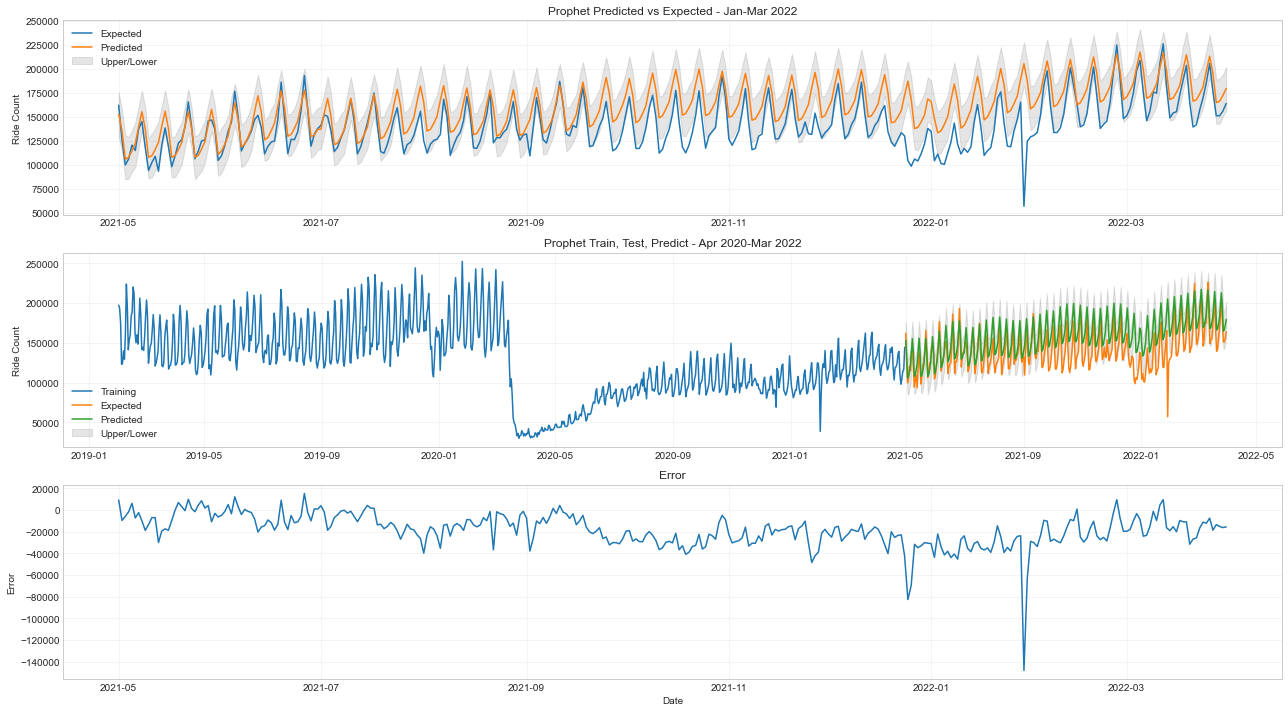

In [46]:
plot_results(prophet_results, 'Prophet', y_train)

In [47]:
get_metrics(prophet_results, metrics, 'prophet', 'control').dropna()

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  23910.85  11.99   5.948    0.0     141329.33     132563.03   
prophet control  23773.53  14.73  -9.736    0.0     141329.33     159535.71   

                observed_std forecast_std  
sarimax control      24706.0     10727.75  
prophet control      24706.0     23615.46

### XGBoost
***

#### Data Preprocessing
***

In [48]:
(X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler) = (MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), 
                                                                  MinMaxScaler())


In [49]:
X_train_scaled = pd.DataFrame(X_train_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
y_train_scaled = pd.DataFrame(y_train_scaler.fit_transform(y_train), index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaler.fit_transform(y_test), index=y_test.index, columns=y_test.columns)

#### Train Model
***

In [50]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [51]:
reg.fit(X_train_scaled, y_train_scaled, eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)], 
        early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

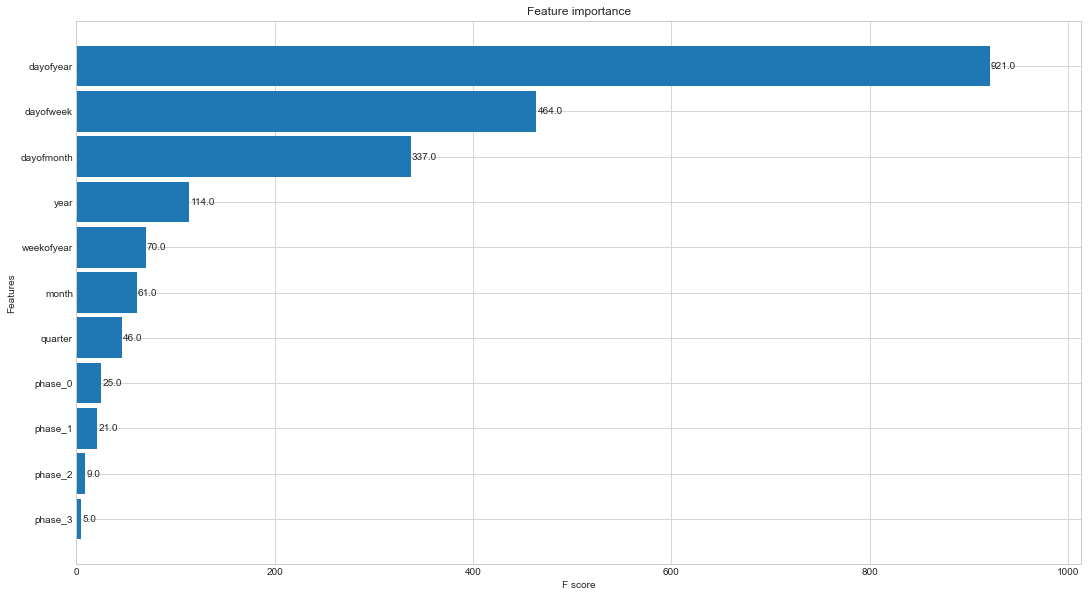

In [52]:
_ = plot_importance(reg, height=0.9)
plt.show()

#### Test Model
***

In [53]:
preds = reg.predict(X_test_scaled)

In [54]:
inverse_preds = y_test_scaler.inverse_transform(pd.DataFrame(preds))

In [55]:
xgb_results = pd.DataFrame(y_test.values, index=y_test.index, columns=['expected'])
xgb_results['predicted'] = pd.DataFrame(inverse_preds)[0].values
xgb_results['error'] = xgb_results.expected - xgb_results.predicted

#### Plot Results
***

In [56]:
xgb_results.head(3)

expected      predicted         error
2021-05-01  162024.0  141996.937500  20027.062500
2021-05-02  125580.0  136532.890625 -10952.890625
2021-05-03   99954.0  134583.859375 -34629.859375

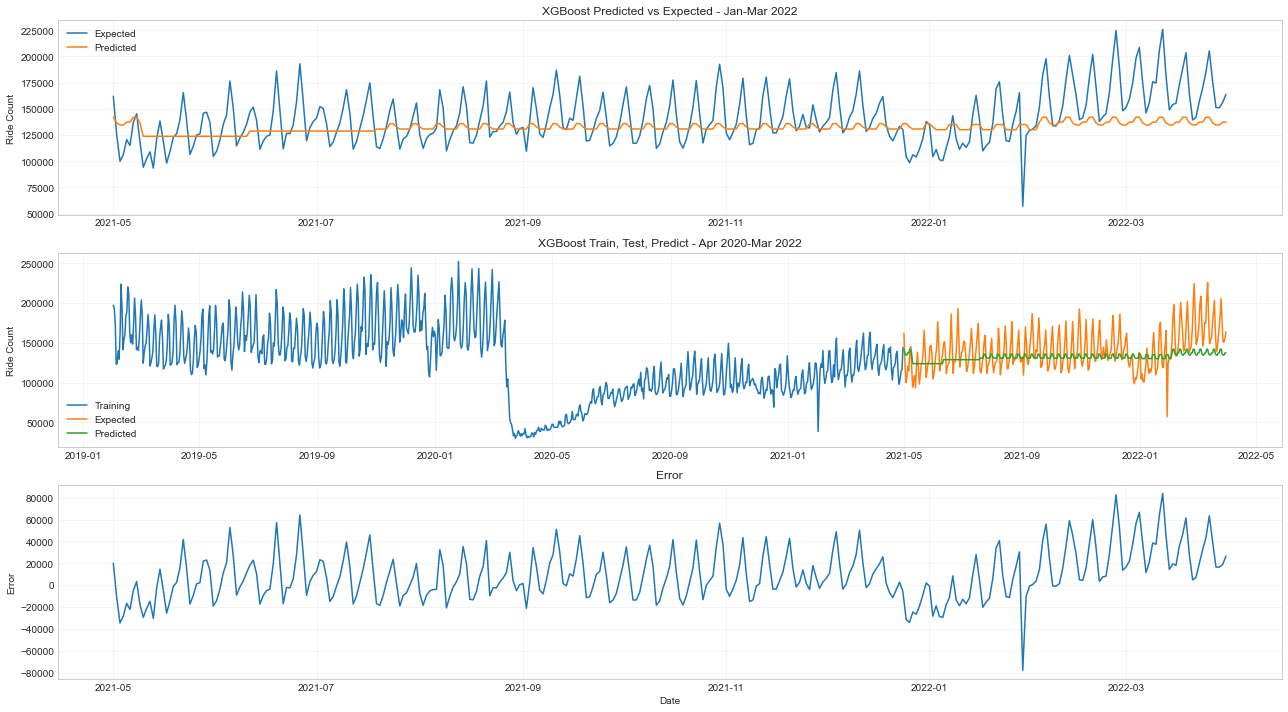

In [57]:
plot_results(xgb_results, 'XGBoost', y_train)

In [58]:
get_metrics(xgb_results, metrics, 'xgboost', 'control').dropna()

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  23910.85  11.99   5.948    0.0     141329.33     132563.03   
prophet control  23773.53  14.73  -9.736    0.0     141329.33     159535.71   
xgboost control  24091.72  12.38   6.639    0.0     141329.33     132216.42   

                observed_std forecast_std  
sarimax control      24706.0     10727.75  
prophet control      24706.0     23615.46  
xgboost control      24706.0       4357.8

***
## Model with Exogenous Variables: Covid Cases, Weather, Competitor Rides
***

### Data Preprocessing: Split Train/Test
***

In [59]:
temp = weather.temp
prec = weather.prec
cases = covid.case
hosp = covid.hospitalized
death = covid.death
vax = vax.vaccination

In [60]:
temp_train, temp_test = split_train_test(temp, train_stop, test_start)
prec_train, prec_test = split_train_test(prec, train_stop, test_start)
cases_train, cases_test = split_train_test(cases, train_stop, test_start)
hosp_train, hosp_test = split_train_test(hosp, train_stop, test_start)
death_train, death_test = split_train_test(death, train_stop, test_start)
vax_train, vax_test = split_train_test(vax, train_stop, test_start)

## Compare Model Performance
***

>Models:
>* **Model 1:** Weather, Temperature
>* **Model 2:** Weather, Precipitation
>* **Model 3:** Covid-19, Cases
>* **Model 4:** Covid-19, Hospitalizations
>* **Model 5:** Covid-19, Deaths
>* **Model 6:** Covid-19, Vaccinations

### SARIMAX <a name='37'/>
***

In [61]:
def get_sarimax(y_train, y_test, X_train, X_test):
    # Get model parameters
    sarimax = auto_arima(y_train, exog=X_train, seasonal=True, m=7, trace=False, stepwise=True)  
    # Train model
    mod = SARIMAX(y_train, exog=X_train, order=sarimax.order, 
                  seasonal_order=sarimax.seasonal_order, m=7).fit(disp=False)   
    # View model summary
    display(mod.summary())  
    # View model diagnostics
    display(ax = mod.plot_diagnostics())
    plt.show()
    # Test model
    fcast = mod.get_forecast(exog=X_test, steps=len(y_test)).summary_frame()
    # Create dataframe from results
    sarimax_results = pd.concat([y_test, fcast], axis=1).dropna()
    sarimax_results.mean_se = y_test.lyft - sarimax_results['mean']
    sarimax_res_cols = ['expected','predicted','error','lower','upper']
    sarimax_results.columns = sarimax_res_cols
    # Display results
    display(sarimax_results.head(3))
    # Plot results
    plot_results(sarimax_results, 'SARIMAX', y_train)
    plt.show()
    # Return results
    return sarimax_results

#### SARIMAX Model 1: Weather, Temperature
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9178.283
Date:                             Thu, 11 Aug 2022   AIC                          18396.566
Time:                                     19:20:43   BIC                          18490.728
Sample:                                 02-01-2019   HQIC                         18432.699
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   4890.1506    177.308     27.580      0.000    4542.634    5237.667
quarter    -7541.6029      0.365  -2.07e+04      0.000   -7542.317   -7540.888
month      -2.067e+04      2.624  -7876.555      0.000   -2.07e+04   -2.07e+04
year       -1.076e+04      0.291  -3.69e+04      0.000   -1.08e+04   -1.08e+04
dayofyear    768.1290     27.420     28.014      0.000     714.387     821.871
dayofmonth  -703.9182     69.427    -10.139      0.000    -839.993    -567.844
weekofyear  -386.1465    832.430     -0.464      0.643   -2017.680    1245.387
phase_0     -299.8963      0.001  -4.35e+05      0.000    -299.898    -299.895
phase_1     6058.2468      0.001   1.08e+07      0.000    6058.246    6058.248
phase_2     2288.0967      0.003   8.32e+05      0.000    2288.091    2288.102
phase_3    -8046.4473      0.003  -3.12e+06      0.000   -8046.452   -8046.442
holiday             0      0.242          0      1.000      -0.475       0.475
temp        -220.2661     62.663     -3.515      0.000    -343.083     -97.449
ar.L1          0.0517      0.369      0.140      0.889      -0.672       0.776
ar.L2          0.9458      0.371      2.549      0.011       0.219       1.673
ma.L1         -0.0518      0.370     -0.140      0.889      -0.778       0.674
ma.L2         -0.9460      0.370     -2.557      0.011      -1.671      -0.221
ar.S.L7        0.9879      0.003    327.185      0.000       0.982       0.994
ma.S.L7       -0.9867      0.003   -311.196      0.000      -0.993      -0.980
sigma2      1.773e+08      0.003   5.11e+10      0.000    1.77e+08    1.77e+08
===================================================================================
Ljung-Box (L1) (Q):                  20.49   Jarque-Bera (JB):                11.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+27. Standard errors may be unstable.
"""

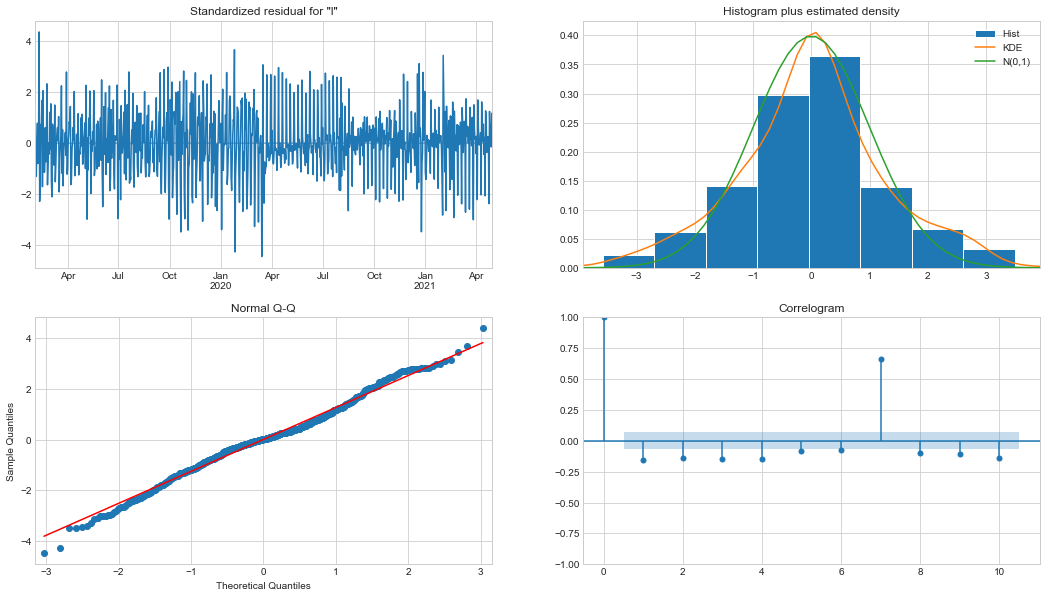

expected      predicted         error          lower  \
2021-05-01  162024.0  150241.816512  11782.183488  124145.772589   
2021-05-02  125580.0  148679.866082 -23099.866082  111776.488017   
2021-05-03   99954.0  120472.770617 -20518.770617   75279.481065   

                    upper  
2021-05-01  176337.860436  
2021-05-02  185583.244147  
2021-05-03  165666.060169

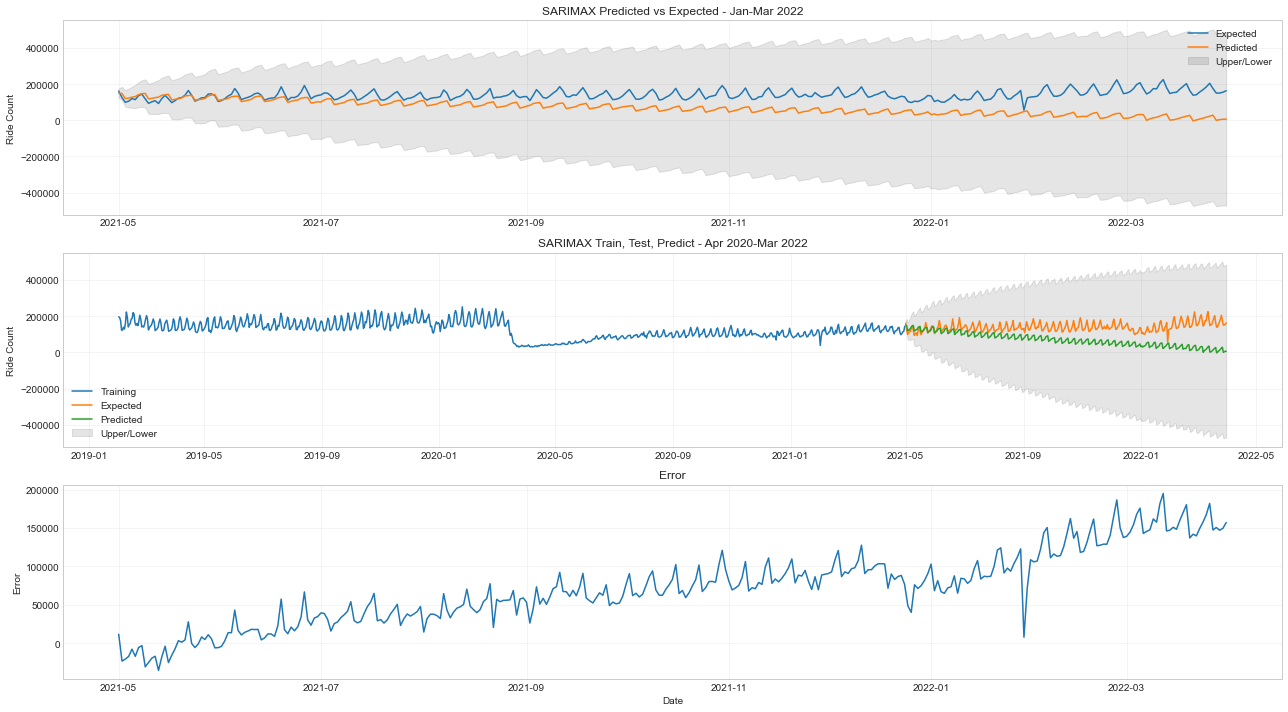

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  23910.85  11.99   5.948    0.0     141329.33     132563.03   
        model_1  85993.42  50.06  29.409    0.0     141329.33      69883.23   
prophet control  23773.53  14.73  -9.736    0.0     141329.33     159535.71   
xgboost control  24091.72  12.38   6.639    0.0     141329.33     132216.42   

                observed_std forecast_std  
sarimax control      24706.0     10727.75  
        model_1      24706.0     36890.12  
prophet control      24706.0     23615.46  
xgboost control      24706.0       4357.8

In [62]:
X_train_1 = pd.concat([X_train, temp_train], axis=1)
X_test_1 = pd.concat([X_test, temp_test], axis=1)
sarimax_mod_1 = get_sarimax(y_train, y_test, X_train_1, X_test_1)
get_metrics(sarimax_mod_1, metrics, 'sarimax', 'model_1').dropna()

#### SARIMAX Model 2: Weather, Precipitation
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9238.012
Date:                             Thu, 11 Aug 2022   AIC                          18516.024
Time:                                     19:21:44   BIC                          18610.185
Sample:                                 02-01-2019   HQIC                         18552.156
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   4933.1359    159.753     30.880      0.000    4620.026    5246.245
quarter    -6118.1337      4.600  -1330.085      0.000   -6127.149   -6109.118
month      -1.567e+04      2.933  -5341.392      0.000   -1.57e+04   -1.57e+04
year       -1.825e+04      0.937  -1.95e+04      0.000   -1.83e+04   -1.83e+04
dayofyear    569.8232     42.140     13.522      0.000     487.230     652.416
dayofmonth  -541.2558     63.348     -8.544      0.000    -665.415    -417.097
weekofyear  -379.6216    666.982     -0.569      0.569   -1686.882     927.639
phase_0    -3229.3908      0.007  -4.72e+05      0.000   -3229.404   -3229.377
phase_1     5213.9060      0.005   1.02e+06      0.000    5213.896    5213.916
phase_2     2097.2027      0.010   2.03e+05      0.000    2097.182    2097.223
phase_3    -4081.7179      0.005  -7.82e+05      0.000   -4081.728   -4081.708
holiday             0    215.070          0      1.000    -421.530     421.530
prec        4014.9147    761.997      5.269      0.000    2521.427    5508.402
ar.L1      -4.467e-05      0.800  -5.58e-05      1.000      -1.568       1.568
ar.L2          0.0009      1.902      0.000      1.000      -3.727       3.729
ma.L1         -0.0002      0.800     -0.000      1.000      -1.568       1.567
ma.L2         -0.0016      1.902     -0.001      0.999      -3.730       3.727
ar.S.L7        0.8929      0.033     27.396      0.000       0.829       0.957
ma.S.L7       -0.8919      0.033    -27.298      0.000      -0.956      -0.828
sigma2      1.764e+08      0.007   2.65e+10      0.000    1.76e+08    1.76e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):                 8.16
Prob(Q):                              0.24   Prob(JB):                         0.02
Heteroskedasticity (H):               0.82   Skew:                            -0.19
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.56e+26. Standard errors may be unstable.
"""

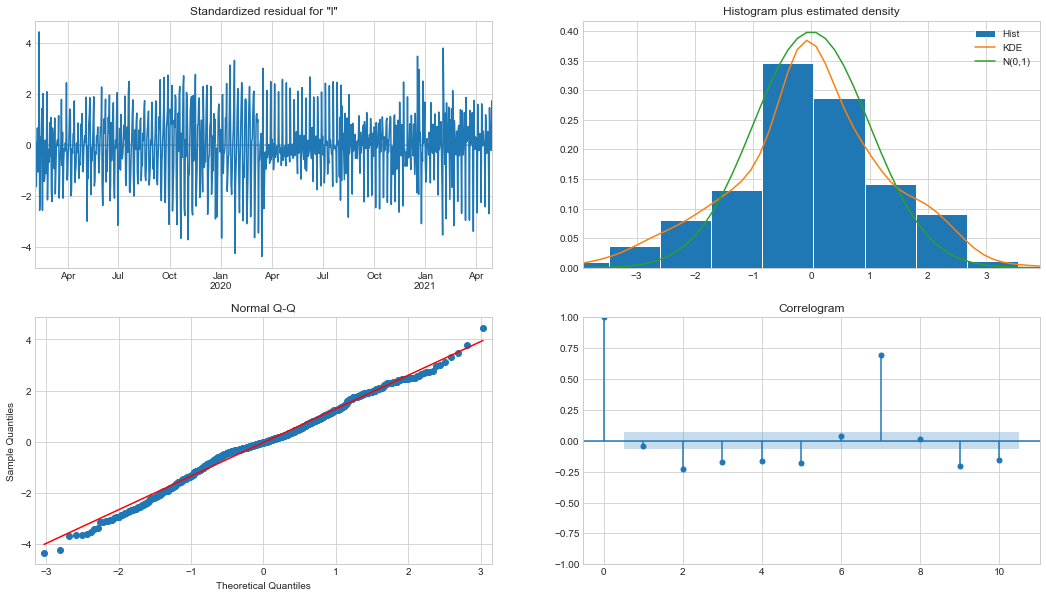

expected      predicted         error          lower  \
2021-05-01  162024.0  149879.655313  12144.344687  123847.354143   
2021-05-02  125580.0  154525.518751 -28945.518751  117715.078308   
2021-05-03   99954.0  127063.114085 -27109.114085   81991.895729   

                    upper  
2021-05-01  175911.956484  
2021-05-02  191335.959195  
2021-05-03  172134.332440

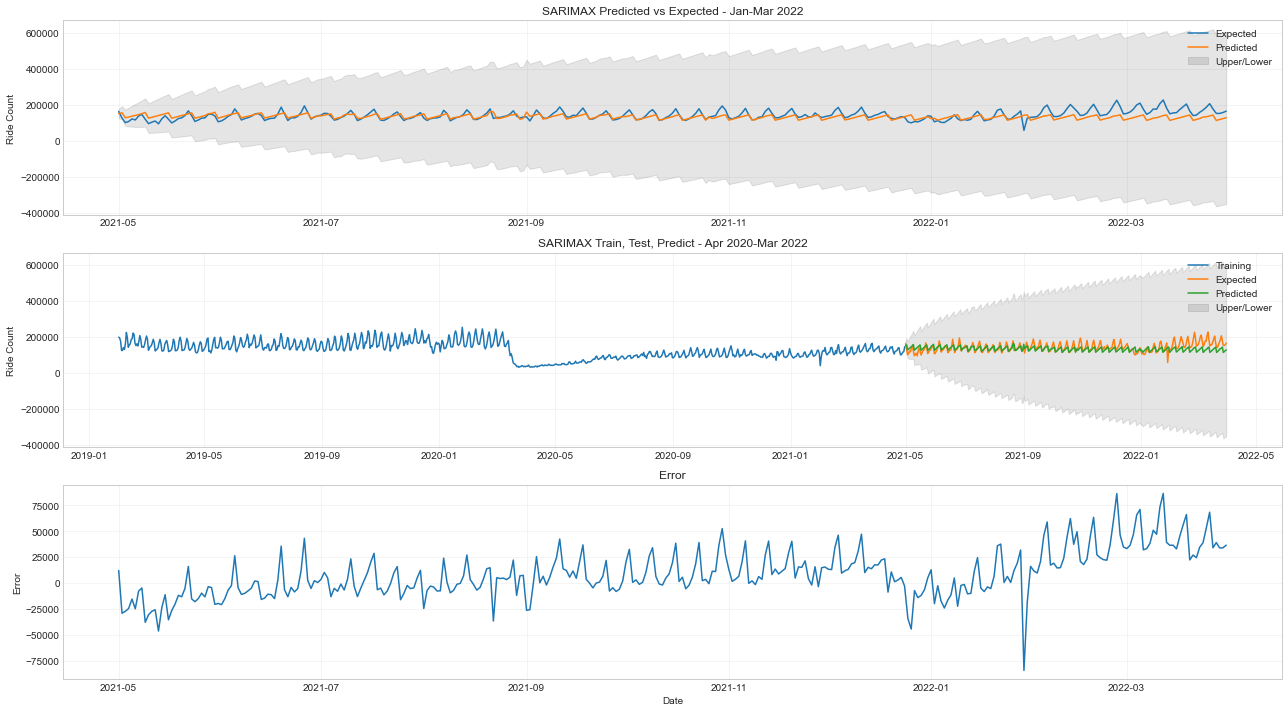

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  23910.85  11.99   5.948    0.0     141329.33     132563.03   
        model_1  85993.42  50.06  29.409    0.0     141329.33      69883.23   
        model_2  24465.21  12.23   6.046    0.0     141329.33     132348.92   
prophet control  23773.53  14.73  -9.736    0.0     141329.33     159535.71   
xgboost control  24091.72  12.38   6.639    0.0     141329.33     132216.42   

                observed_std forecast_std  
sarimax control      24706.0     10727.75  
        model_1      24706.0     36890.12  
        model_2      24706.0     11250.61  
prophet control      24706.0     23615.46  
xgboost control      24706.0       4357.8

In [63]:
X_train_2 = pd.concat([X_train, prec_train], axis=1)
X_test_2 = pd.concat([X_test, prec_test], axis=1)
sarimax_mod_2 = get_sarimax(y_train, y_test, X_train_2, X_test_2)
get_metrics(sarimax_mod_2, metrics, 'sarimax', 'model_2').dropna()

#### SARIMAX Model 3: Covid-19, Cases

***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9233.339
Date:                             Thu, 11 Aug 2022   AIC                          18506.678
Time:                                     19:22:45   BIC                          18600.839
Sample:                                 02-01-2019   HQIC                         18542.810
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   4897.0279    233.911     20.935      0.000    4438.571    5355.485
quarter    -7183.3940     13.964   -514.425      0.000   -7210.763   -7156.025
month      -2.474e+04      2.946  -8398.473      0.000   -2.47e+04   -2.47e+04
year       -1.841e+04      1.613  -1.14e+04      0.000   -1.84e+04   -1.84e+04
dayofyear    876.1267     46.155     18.982      0.000     785.664     966.590
dayofmonth  -843.0551     70.692    -11.926      0.000    -981.608    -704.502
weekofyear  -380.2930   1254.799     -0.303      0.762   -2839.655    2079.069
phase_0    -2572.4768      0.013  -1.94e+05      0.000   -2572.503   -2572.451
phase_1     5823.6450      0.013   4.48e+05      0.000    5823.620    5823.671
phase_2     2871.0370      0.006   4.92e+05      0.000    2871.026    2871.048
phase_3    -6122.2052      0.002  -2.59e+06      0.000   -6122.210   -6122.201
holiday             0    128.952          0      1.000    -252.742     252.742
case           3.5808      3.774      0.949      0.343      -3.816      10.977
ar.L1      -4.861e-05      0.839  -5.79e-05      1.000      -1.645       1.644
ar.L2          0.0007      1.998      0.000      1.000      -3.914       3.916
ma.L1         -0.0002      0.838     -0.000      1.000      -1.644       1.643
ma.L2         -0.0014      1.998     -0.001      0.999      -3.917       3.914
ar.S.L7        0.8866      0.036     24.391      0.000       0.815       0.958
ma.S.L7       -0.8856      0.036    -24.304      0.000      -0.957      -0.814
sigma2      1.836e+08      0.028   6.63e+09      0.000    1.84e+08    1.84e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 7.52
Prob(Q):                              0.21   Prob(JB):                         0.02
Heteroskedasticity (H):               0.76   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+28. Standard errors may be unstable.
"""

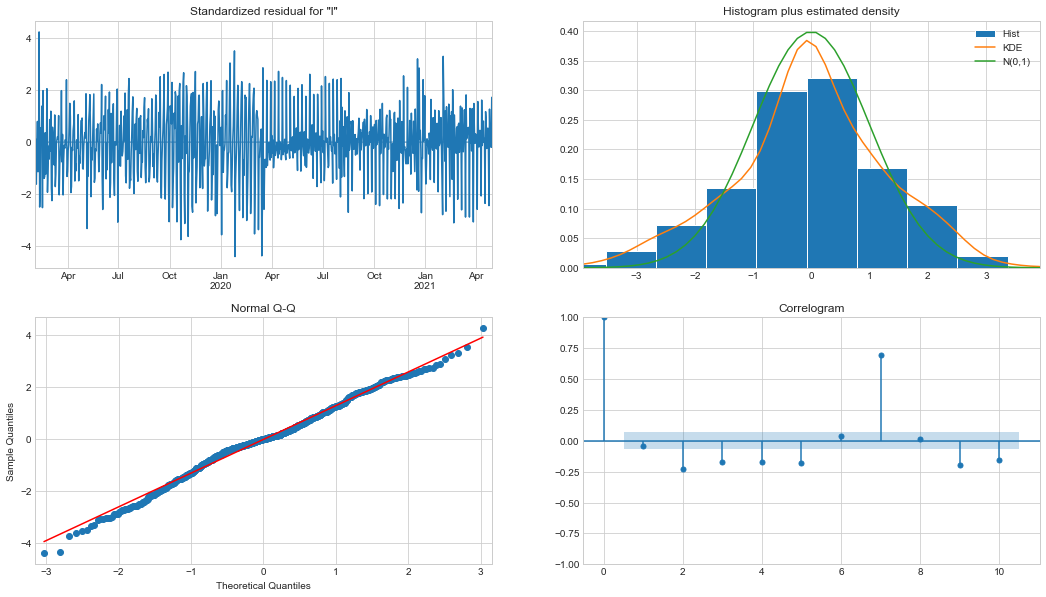

expected      predicted         error          lower  \
2021-05-01  162024.0  149812.533814  12211.466186  123256.412872   
2021-05-02  125580.0  154347.997503 -28767.997503  116796.768726   
2021-05-03   99954.0  124546.179791 -24592.179791   78567.775031   

                    upper  
2021-05-01  176368.654755  
2021-05-02  191899.226280  
2021-05-03  170524.584550

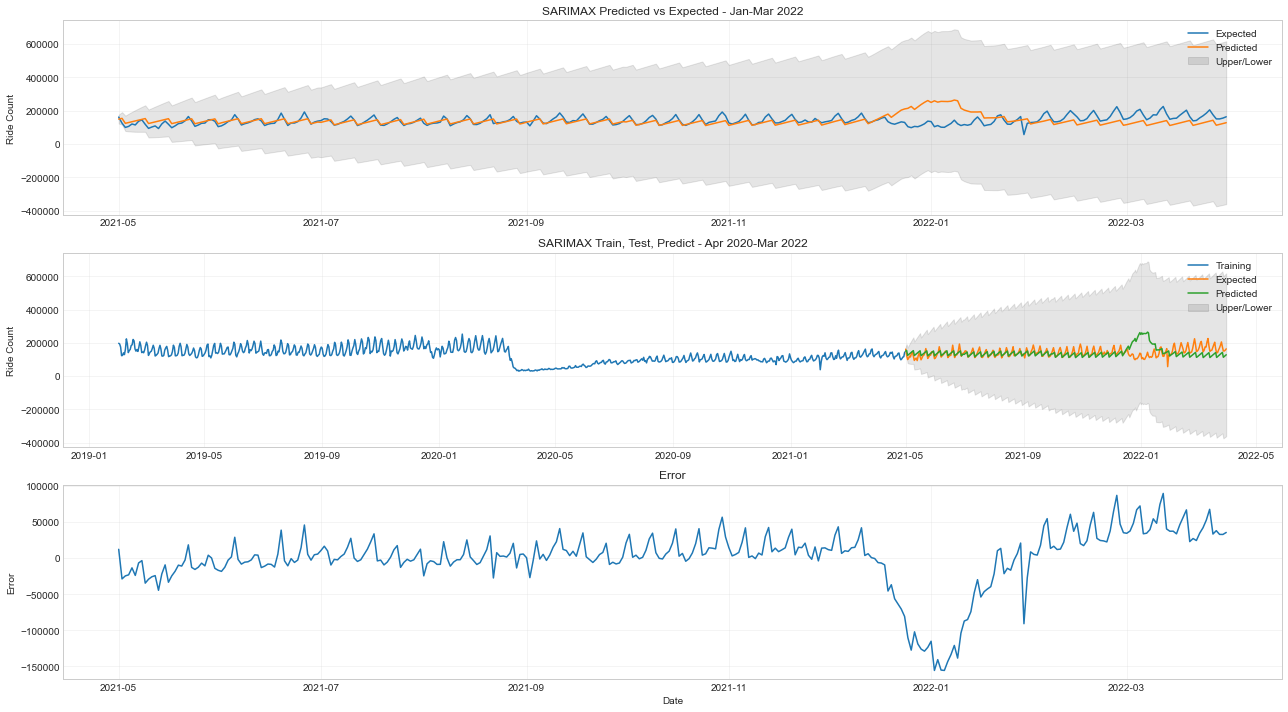

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
prophet control     159535.71      24706.0     23615.46  
xgboost control     132216.42      24706.0       4357.8

In [64]:
X_train_3 = pd.concat([X_train, cases_train], axis=1)
X_test_3 = pd.concat([X_test, cases_test], axis=1)
sarimax_mod_3 = get_sarimax(y_train, y_test, X_train_3, X_test_3)
get_metrics(sarimax_mod_3, metrics, 'sarimax', 'model_3').dropna()

#### SARIMAX Model 4: Covid-19, Hospitalizations
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9246.287
Date:                             Thu, 11 Aug 2022   AIC                          18532.574
Time:                                     19:23:44   BIC                          18626.735
Sample:                                 02-01-2019   HQIC                         18568.706
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dayofweek     4896.7164    202.161     24.222      0.000    4500.488    5292.945
quarter      -6903.2552      7.945   -868.916      0.000   -6918.826   -6887.684
month        -2.246e+04      2.730  -8224.596      0.000   -2.25e+04   -2.25e+04
year         -1.559e+04      0.143  -1.09e+05      0.000   -1.56e+04   -1.56e+04
dayofyear      805.6832     44.414     18.140      0.000     718.634     892.733
dayofmonth    -761.8563     64.997    -11.721      0.000    -889.249    -634.464
weekofyear    -387.8298   1024.603     -0.379      0.705   -2396.016    1620.356
phase_0      -2566.5214      0.008  -3.32e+05      0.000   -2566.537   -2566.506
phase_1       6138.3133      0.006   1.02e+06      0.000    6138.302    6138.325
phase_2       2889.8020      0.005   5.76e+05      0.000    2889.792    2889.812
phase_3      -6461.5939      0.002  -2.81e+06      0.000   -6461.598   -6461.589
holiday               0    130.078          0      1.000    -254.948     254.948
hospitalized   -21.8526     21.713     -1.006      0.314     -64.410      20.705
ar.L1        -3.865e-05      0.803  -4.82e-05      1.000      -1.573       1.573
ar.L2            0.0014      1.909      0.001      0.999      -3.740       3.742
ma.L1           -0.0003      0.802     -0.000      1.000      -1.572       1.572
ma.L2           -0.0022      1.909     -0.001      0.999      -3.744       3.739
ar.S.L7          0.8860      0.034     26.197      0.000       0.820       0.952
ma.S.L7         -0.8848      0.034    -26.087      0.000      -0.951      -0.818
sigma2        1.749e+08      0.018   9.95e+09      0.000    1.75e+08    1.75e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.18   Prob(JB):                         0.02
Heteroskedasticity (H):               0.76   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+27. Standard errors may be unstable.
"""

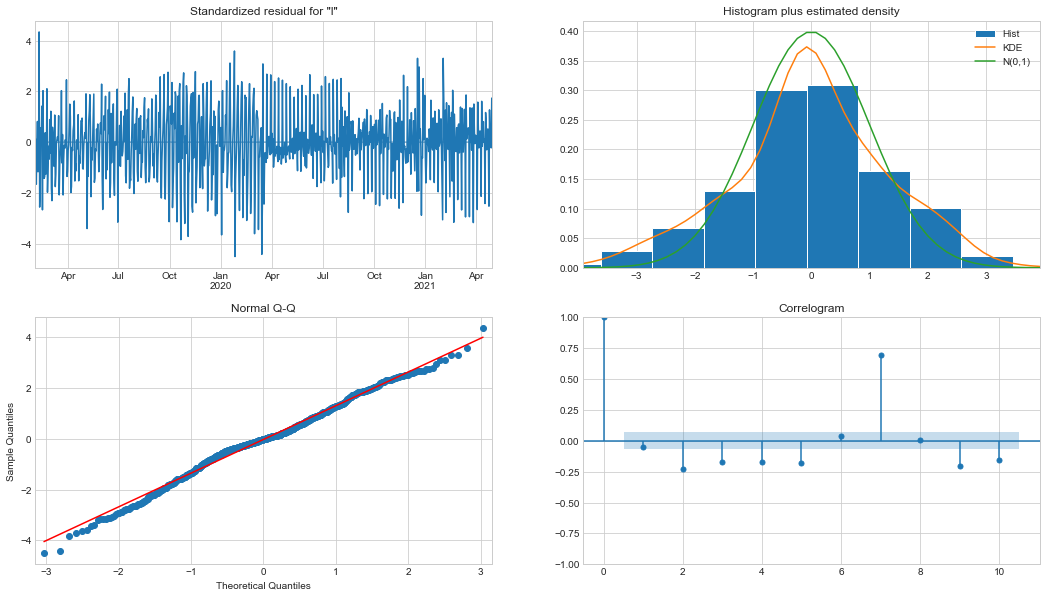

expected      predicted         error          lower  \
2021-05-01  162024.0  149875.309611  12148.690389  123951.429532   
2021-05-02  125580.0  154607.623451 -29027.623451  117951.319243   
2021-05-03   99954.0  125237.525889 -25283.525889   80357.075909   

                    upper  
2021-05-01  175799.189689  
2021-05-02  191263.927659  
2021-05-03  170117.975868

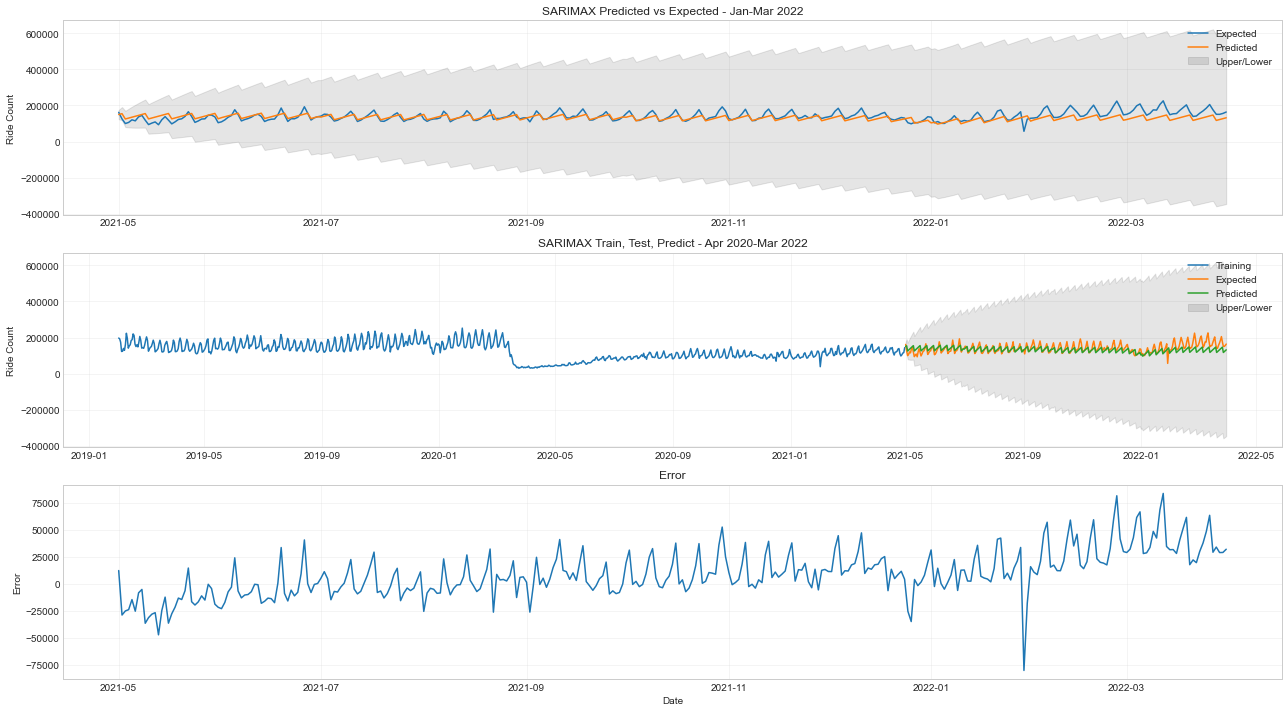

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
prophet control     159535.71      24706.0     23615.46  
xgboost control     132216.42      24706.0       4357.8

In [65]:
X_train_4 = pd.concat([X_train, hosp_train], axis=1)
X_test_4 = pd.concat([X_test, hosp_test], axis=1)
sarimax_mod_4 = get_sarimax(y_train, y_test, X_train_4, X_test_4)
get_metrics(sarimax_mod_4, metrics, 'sarimax', 'model_4').dropna()

#### SARIMAX Model 5: Covid-19, Death
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9241.206
Date:                             Thu, 11 Aug 2022   AIC                          18522.412
Time:                                     19:24:50   BIC                          18616.574
Sample:                                 02-01-2019   HQIC                         18558.544
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   4896.7643    209.340     23.391      0.000    4486.465    5307.064
quarter    -7023.7811      8.370   -839.122      0.000   -7040.187   -7007.375
month      -2.209e+04      2.783  -7938.108      0.000   -2.21e+04   -2.21e+04
year       -1.657e+04      0.330  -5.02e+04      0.000   -1.66e+04   -1.66e+04
dayofyear    792.2793     44.989     17.610      0.000     704.102     880.457
dayofmonth  -751.5533     66.360    -11.325      0.000    -881.616    -621.490
weekofyear  -386.3781   1074.867     -0.359      0.719   -2493.078    1720.322
phase_0    -2467.8134      0.009  -2.83e+05      0.000   -2467.830   -2467.796
phase_1     5999.6964      0.008   7.11e+05      0.000    5999.680    5999.713
phase_2     2907.2061      0.005   6.06e+05      0.000    2907.197    2907.216
phase_3    -6439.0892      0.002  -3.29e+06      0.000   -6439.093   -6439.085
holiday             0    109.480          0      1.000    -214.577     214.577
death         -6.6017     77.696     -0.085      0.932    -158.883     145.680
ar.L1       -3.63e-05      0.820  -4.43e-05      1.000      -1.607       1.607
ar.L2          0.0015      1.945      0.001      0.999      -3.812       3.814
ma.L1         -0.0003      0.819     -0.000      1.000      -1.606       1.605
ma.L2         -0.0022      1.946     -0.001      0.999      -3.816       3.811
ar.S.L7        0.8843      0.036     24.785      0.000       0.814       0.954
ma.S.L7       -0.8832      0.036    -24.688      0.000      -0.953      -0.813
sigma2      1.785e+08      0.022    8.1e+09      0.000    1.79e+08    1.79e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):                 7.61
Prob(Q):                              0.19   Prob(JB):                         0.02
Heteroskedasticity (H):               0.76   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+27. Standard errors may be unstable.
"""

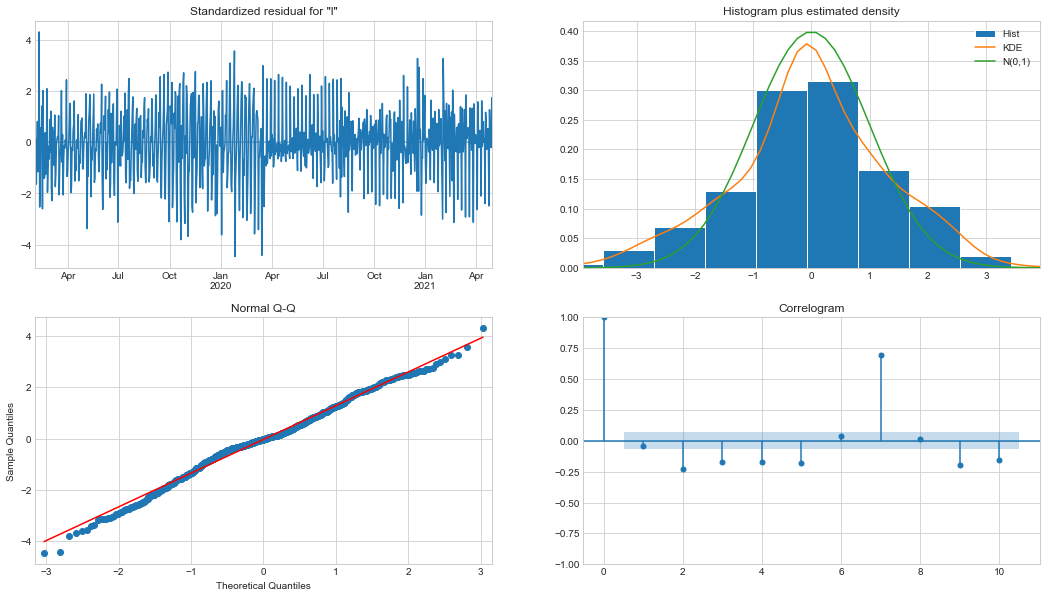

expected      predicted         error          lower  \
2021-05-01  162024.0  149854.925585  12169.074415  123668.070247   
2021-05-02  125580.0  154453.935044 -28873.935044  117425.436825   
2021-05-03   99954.0  124905.911584 -24951.911584   79568.911845   

                    upper  
2021-05-01  176041.780923  
2021-05-02  191482.433262  
2021-05-03  170242.911323

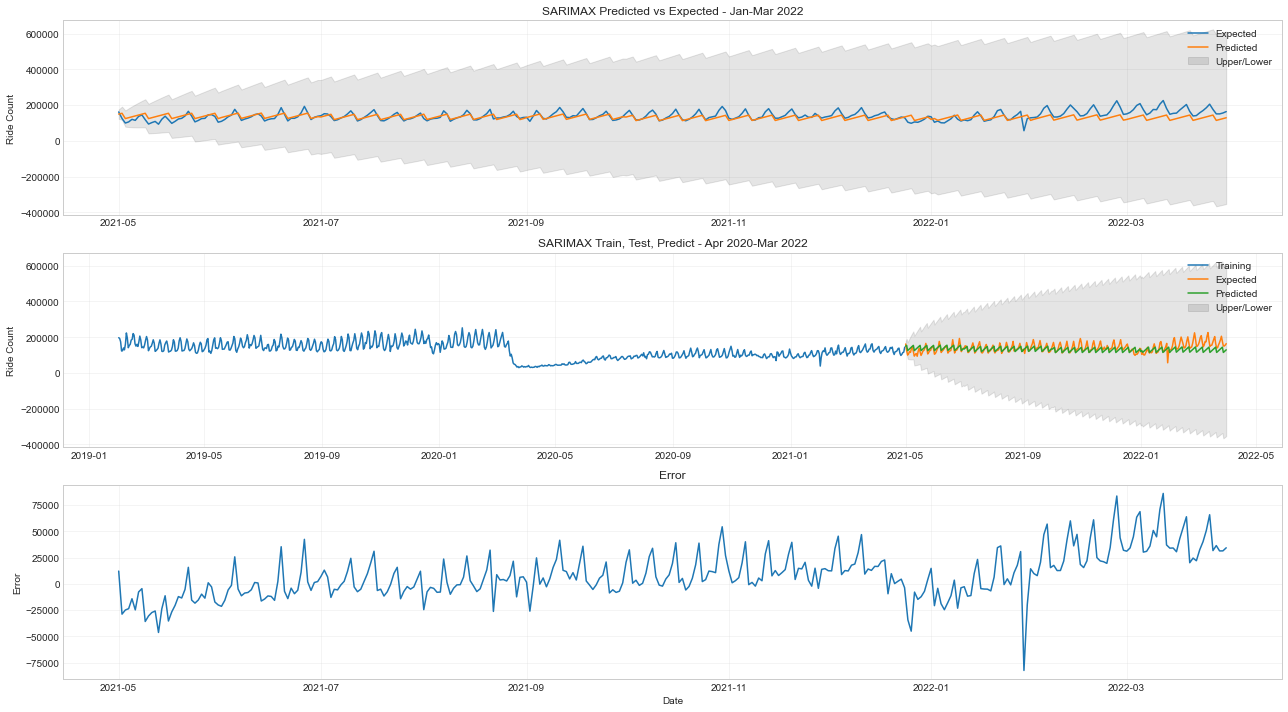

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
prophet control     159535.71      24706.0     23615.46  
xgboost control     132216.42      24706.0       4357.8

In [66]:
X_train_5 = pd.concat([X_train, death_train], axis=1)
X_test_5 = pd.concat([X_test, death_test], axis=1)
sarimax_mod_5 = get_sarimax(y_train, y_test, X_train_5, X_test_5)
get_metrics(sarimax_mod_5, metrics, 'sarimax', 'model_5').dropna()

#### SARIMAX Model 6: Covid-19, Vaccinations
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                lyft   No. Observations:                  820
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -9236.667
Date:                             Thu, 11 Aug 2022   AIC                          18513.334
Time:                                     19:26:00   BIC                          18607.496
Sample:                                 02-01-2019   HQIC                         18549.467
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dayofweek    4898.5871    207.222     23.639      0.000    4492.439    5304.735
quarter     -7067.8888      9.877   -715.611      0.000   -7087.247   -7048.531
month       -2.172e+04      2.778  -7817.827      0.000   -2.17e+04   -2.17e+04
year        -1.359e+04      1.200  -1.13e+04      0.000   -1.36e+04   -1.36e+04
dayofyear     788.4849     44.849     17.581      0.000     700.583     876.387
dayofmonth   -739.1357     66.257    -11.156      0.000    -868.997    -609.275
weekofyear   -386.2289   1098.004     -0.352      0.725   -2538.278    1765.820
phase_0      7822.1728      0.011    7.1e+05      0.000    7822.151    7822.194
phase_1      1.628e+04      0.010    1.6e+06      0.000    1.63e+04    1.63e+04
phase_2      1.318e+04      0.006   2.38e+06      0.000    1.32e+04    1.32e+04
phase_3     -3.728e+04      0.005   -7.8e+06      0.000   -3.73e+04   -3.73e+04
holiday              0    658.880          0      1.000   -1291.381    1291.381
vaccination     0.3944      0.210      1.877      0.061      -0.017       0.806
ar.L1           0.0328      0.986      0.033      0.973      -1.899       1.965
ar.L2           0.0343      2.266      0.015      0.988      -4.406       4.475
ma.L1          -0.0332      0.984     -0.034      0.973      -1.962       1.895
ma.L2          -0.0352      2.266     -0.016      0.988      -4.476       4.406
ar.S.L7         0.8841      0.035     25.600      0.000       0.816       0.952
ma.S.L7        -0.8826      0.035    -25.478      0.000      -0.951      -0.815
sigma2       1.783e+08      0.019   9.24e+09      0.000    1.78e+08    1.78e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):                 7.34
Prob(Q):                              0.20   Prob(JB):                         0.03
Heteroskedasticity (H):               0.75   Skew:                            -0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+27. Standard errors may be unstable.
"""

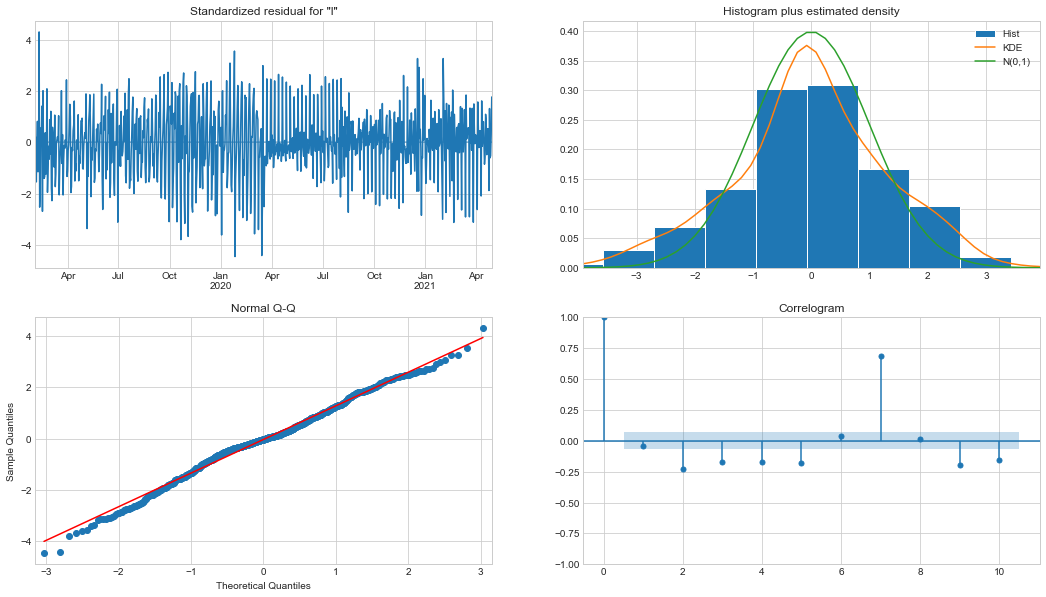

expected      predicted         error          lower  \
2021-05-01  162024.0  135211.832615  26812.167385  109043.808421   
2021-05-02  125580.0  131767.960717  -6187.960717   94767.633138   
2021-05-03   99954.0  104871.631162  -4917.631162   59572.793972   

                    upper  
2021-05-01  161379.856809  
2021-05-02  168768.288297  
2021-05-03  150170.468352

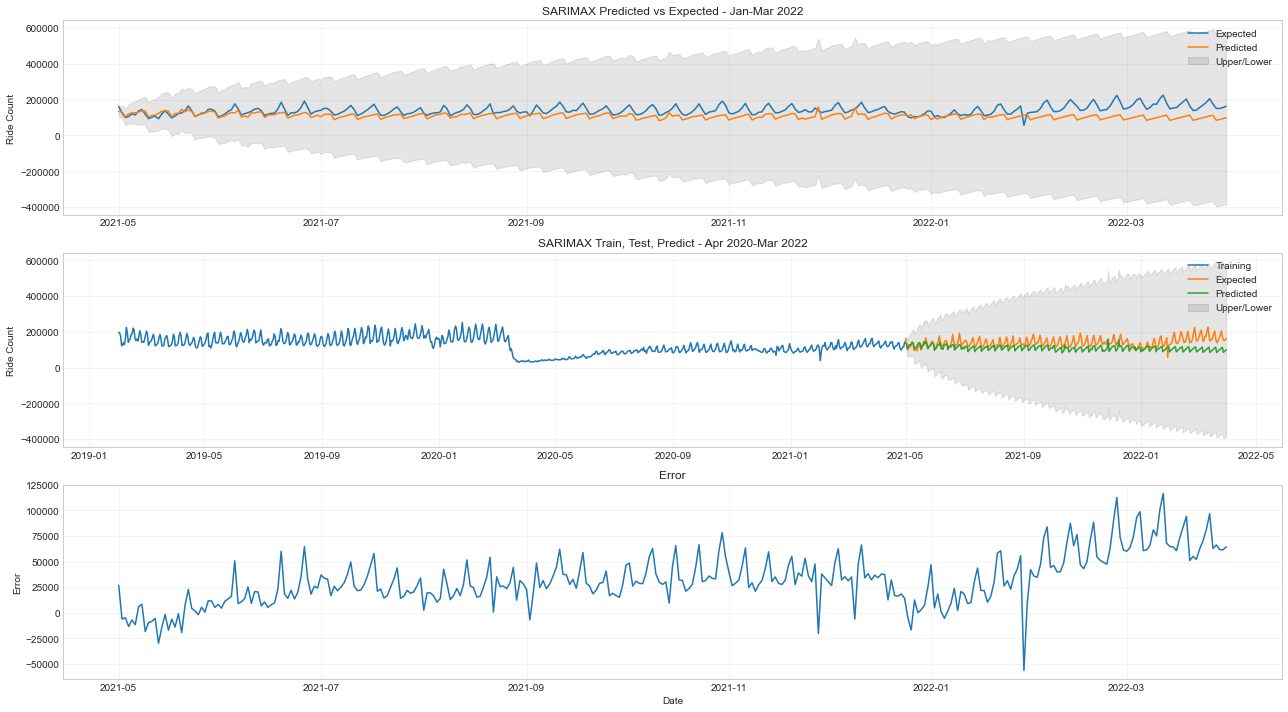

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
xgboost control     132216.42      24706.0       4357.8

In [67]:
X_train_6 = pd.concat([X_train, vax_train], axis=1)
X_test_6 = pd.concat([X_test, vax_test], axis=1)
sarimax_mod_6 = get_sarimax(y_train, y_test, X_train_6, X_test_6)
get_metrics(sarimax_mod_6, metrics, 'sarimax', 'model_6').dropna()

### Prophet
***

In [68]:
def get_prophet(train, regressors, test):
    # Create model
    m = Prophet(daily_seasonality=7)
    # Add regressors
    for col in regressors.columns:
        m.add_regressor(col)
    # Train model
    m.fit(train)
    # Make future dataframe    
    future = m.make_future_dataframe(periods=len(test), freq='D')
    future = pd.concat([future, regressors], axis=1)
    # Forecast
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    # Make results dataframe
    results = forecast.set_index('ds')
    results.index.name = None
    train_test = pd.concat([train[['y']], test[['y']]]).reset_index(drop=True)
    results['expected'] = train_test.values
    results['error'] = (results.expected - results.yhat)/2
    results.columns.values[:-2] = ['predicted', 'lower', 'upper']
    results = results[['expected', 'predicted', 'error', 'lower', 'upper']]
    results = results[test_start:]
    # Display results
    display(results.head(3))
    # Plot results
    plot_results(results, 'Prophet', train.set_index('ds')['y'])
    plt.show()
    # Return results
    return results

#### Prophet Model 1: Weather, Temperature
***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1782.62   0.000711362       103.628           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1784.17      0.000274       92.1176      0.9085      0.9085      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       1784.36   0.000177363       85.1279   2.547e-06       0.001      337  LS failed, Hessian reset 
     299       1784.43   9.60341e-06       93.6058           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1784.44   2.50489e-05       99.0511    3.03e-07       0.001      474  LS failed, Hessian reset 
     350       1784.44   5.79648e-08       81.0901       0.308           1      515   
Optimization terminat

expected      predicted        error          lower          upper
2021-05-01  162024.0  153777.689052  4123.155474  131487.909176  176532.397765
2021-05-02  125580.0  135031.467188 -4725.733594  112560.968910  156097.255645
2021-05-03   99954.0  106431.169638 -3238.584819   85522.502680  128523.816486

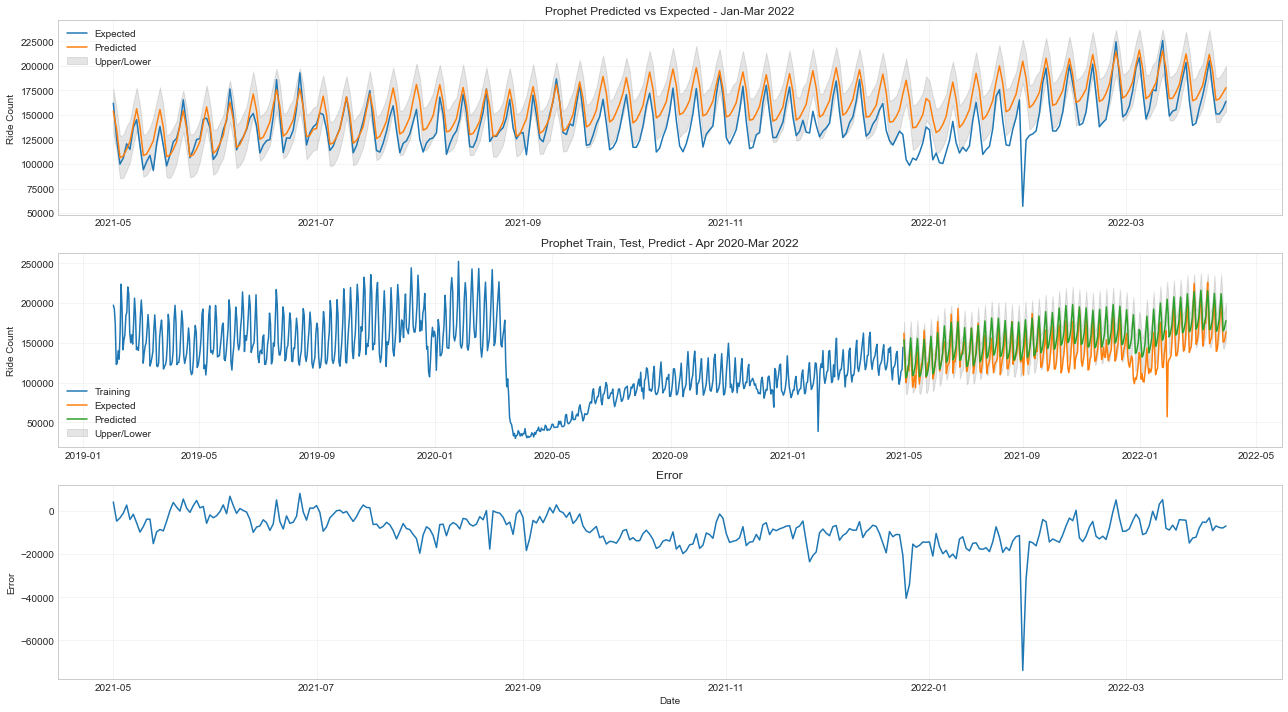

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
xgboost control     132216.42      24706.0       4357.8

In [69]:
prophet_1_train = pd.concat([prophet_train, temp_train.reset_index(drop=True)], axis=1)
prophet_1_test = pd.concat([regressors, temp], axis=1).reset_index(drop=True)
prophet_1_results = get_prophet(prophet_1_train, prophet_1_test, prophet_test)
get_metrics(prophet_1_results, metrics, 'prophet', 'model_1').dropna()

#### Prophet Model 2: Weather, Precipitation

***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1787.73    0.00108794       110.934           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       1788.51   2.93809e-05       81.8619   2.934e-07       0.001      257  LS failed, Hessian reset 
     199       1788.52    4.3657e-06       82.2138      0.2682           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       1788.81   0.000494284       178.733    4.53e-06       0.001      360  LS failed, Hessian reset 
     283       1789.06   8.04605e-05        67.083   1.167e-06       0.001      451  LS failed, Hessian reset 
     299       1789.07   1.24068e-05       81.7684      0.3035           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

expected      predicted        error          lower          upper
2021-05-01  162024.0  153417.936361  4303.031819  131668.250947  177377.995911
2021-05-02  125580.0  135590.366412 -5005.183206  114427.477833  156366.476687
2021-05-03   99954.0  109688.237262 -4867.118631   89304.482013  132805.020764

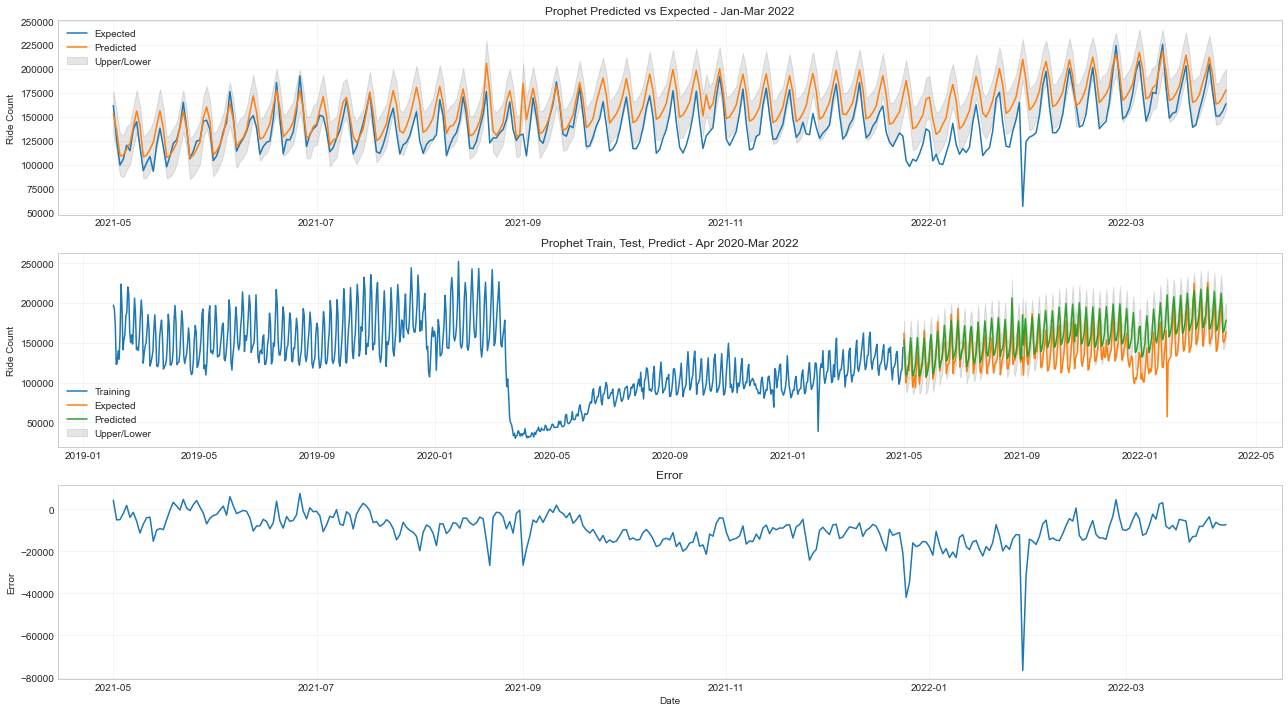

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
xgboost control     132216.42      24706.0       4357.8

In [70]:
prophet_2_train = pd.concat([prophet_train, prec_train.reset_index(drop=True)], axis=1)
prophet_2_test = pd.concat([regressors, prec], axis=1).reset_index(drop=True)
prophet_2_results = get_prophet(prophet_2_train, prophet_2_test, prophet_test)
get_metrics(prophet_2_results, metrics, 'prophet', 'model_2').dropna()

#### Prophet Model 3: Covid-19, Cases

***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1835.86    0.00110666       183.308           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       1838.69   0.000114748       119.962   9.251e-07       0.001      252  LS failed, Hessian reset 
     199       1838.77   0.000180878       89.5543      0.9661      0.9661      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       1838.91   0.000160854       137.391   1.563e-06       0.001      423  LS failed, Hessian reset 
     299       1838.92   4.81059e-05        68.752           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1838.93   6.55409e-06       80.9683   7.832e-08       0.001      497  LS failed, Hessian rese

expected      predicted        error          lower          upper
2021-05-01  162024.0  153501.571530  4261.214235  131876.911215  173776.652621
2021-05-02  125580.0  135778.610352 -5099.305176  114832.630447  154405.709289
2021-05-03   99954.0  106956.922730 -3501.461365   87090.724350  127383.103790

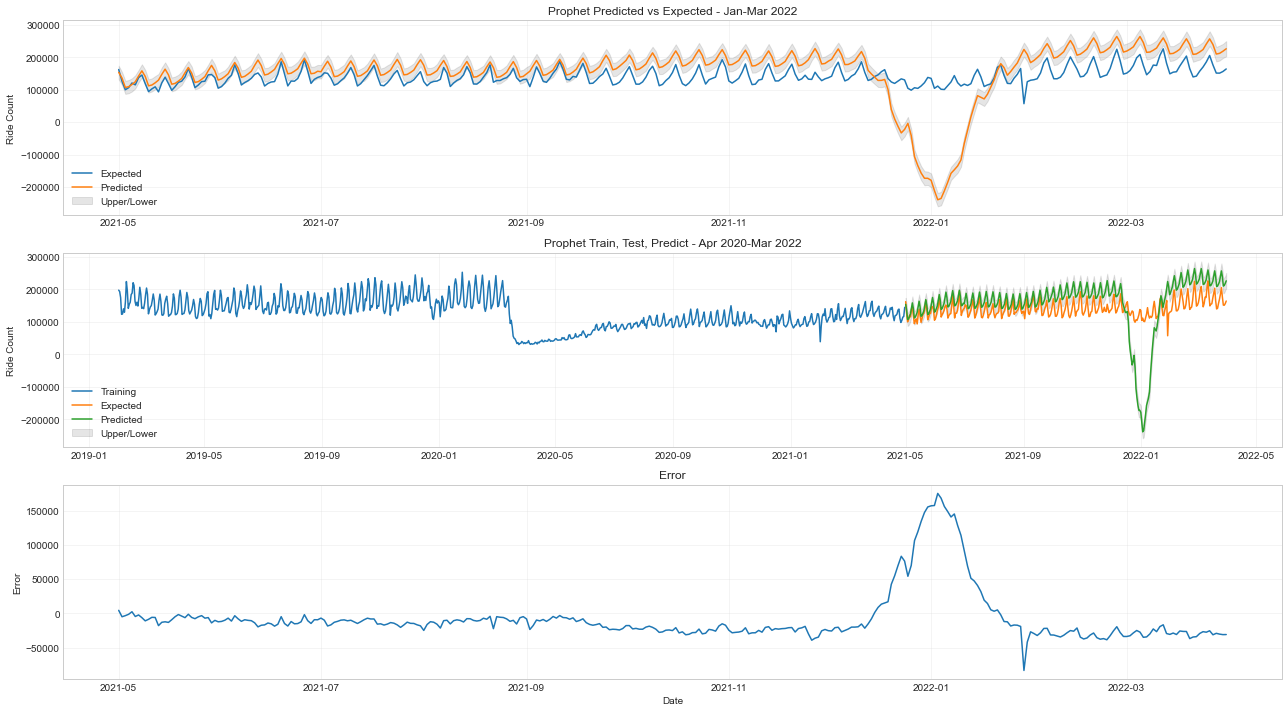

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
xgboost control     132216.42      24706.0       4357.8

In [71]:
prophet_3_train = pd.concat([prophet_train, cases_train.reset_index(drop=True)], axis=1)
prophet_3_test = pd.concat([regressors, cases], axis=1).reset_index(drop=True)
prophet_3_results = get_prophet(prophet_3_train, prophet_3_test, prophet_test)
get_metrics(prophet_3_results, metrics, 'prophet', 'model_3').dropna()

#### Prophet Model 4: Covid-19, Hospitalizations

***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.02    0.00398435       138.167           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       1823.65   0.000237006       190.887   1.613e-06       0.001      209  LS failed, Hessian reset 
     199       1823.84     0.0012937       88.3385           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       1824.05    0.00046029       111.925   4.524e-06       0.001      316  LS failed, Hessian reset 
     290        1824.2   0.000177357       131.989   1.617e-06       0.001      458  LS failed, Hessian reset 
     299       1824.25   0.000237124        82.784           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

expected      predicted        error          lower          upper
2021-05-01  162024.0  148354.868905  6834.565548  128664.349099  168815.530712
2021-05-02  125580.0  130528.387335 -2474.193667  110626.983821  151390.218996
2021-05-03   99954.0  101178.154730  -612.077365   82073.950976  122801.803713

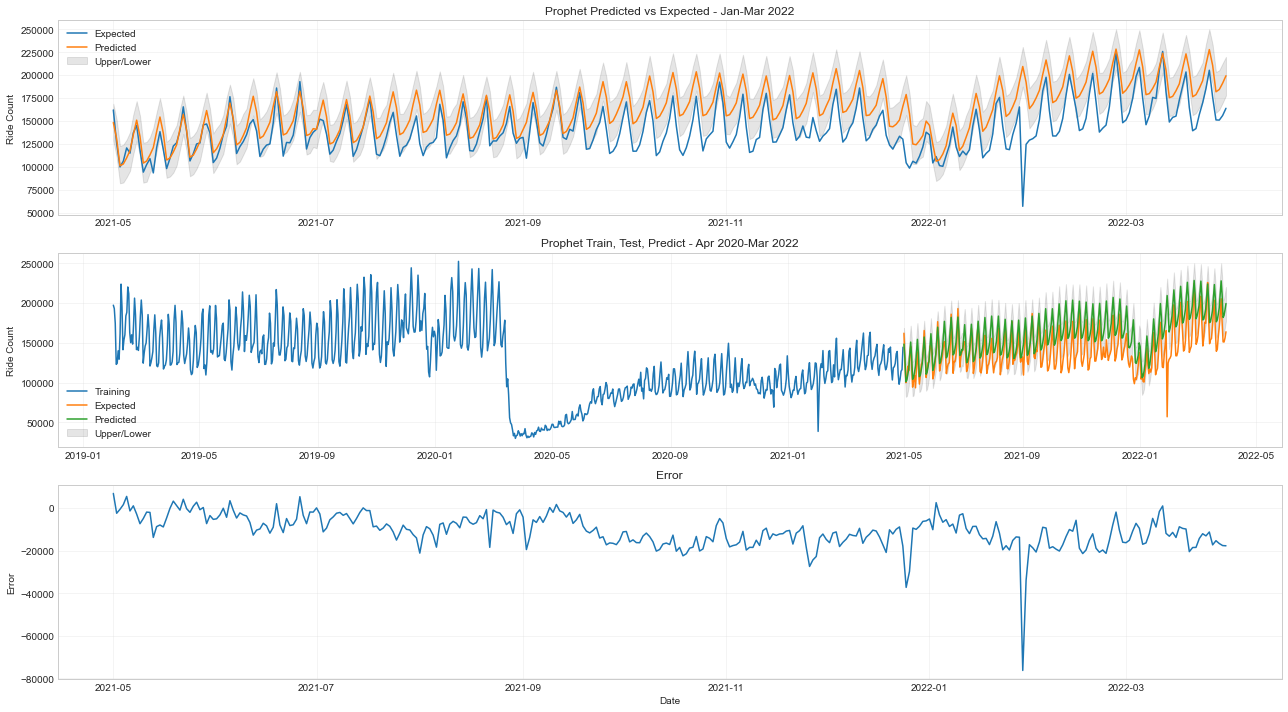

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
xgboost control     132216.42      24706.0       4357.8

In [72]:
prophet_4_train = pd.concat([prophet_train, hosp_train.reset_index(drop=True)], axis=1)
prophet_4_test = pd.concat([regressors, hosp], axis=1).reset_index(drop=True)
prophet_4_results = get_prophet(prophet_4_train, prophet_4_test, prophet_test)
get_metrics(prophet_4_results, metrics, 'prophet', 'model_4').dropna()

#### Prophet Model 5: Covid-19, Deaths

***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1805.68   0.000795956       63.8118      0.4056           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1806.85    0.00014958       80.9904           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1806.94    0.00572932       168.716      0.9287      0.9287      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1807.53   7.04902e-05       78.8737      0.3409      0.3409      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       1807.54    6.0983e-06       93.2255   8.113e-08       0.001      625  LS failed, Hessian reset 
     498       1807.54   9.96764e-08    

expected      predicted        error          lower          upper
2021-05-01  162024.0  146991.218396  7516.390802  124421.367122  167869.094145
2021-05-02  125580.0  128534.293872 -1477.146936  107960.109774  149530.907061
2021-05-03   99954.0   98638.665912   657.667044   78441.515748  120670.488251

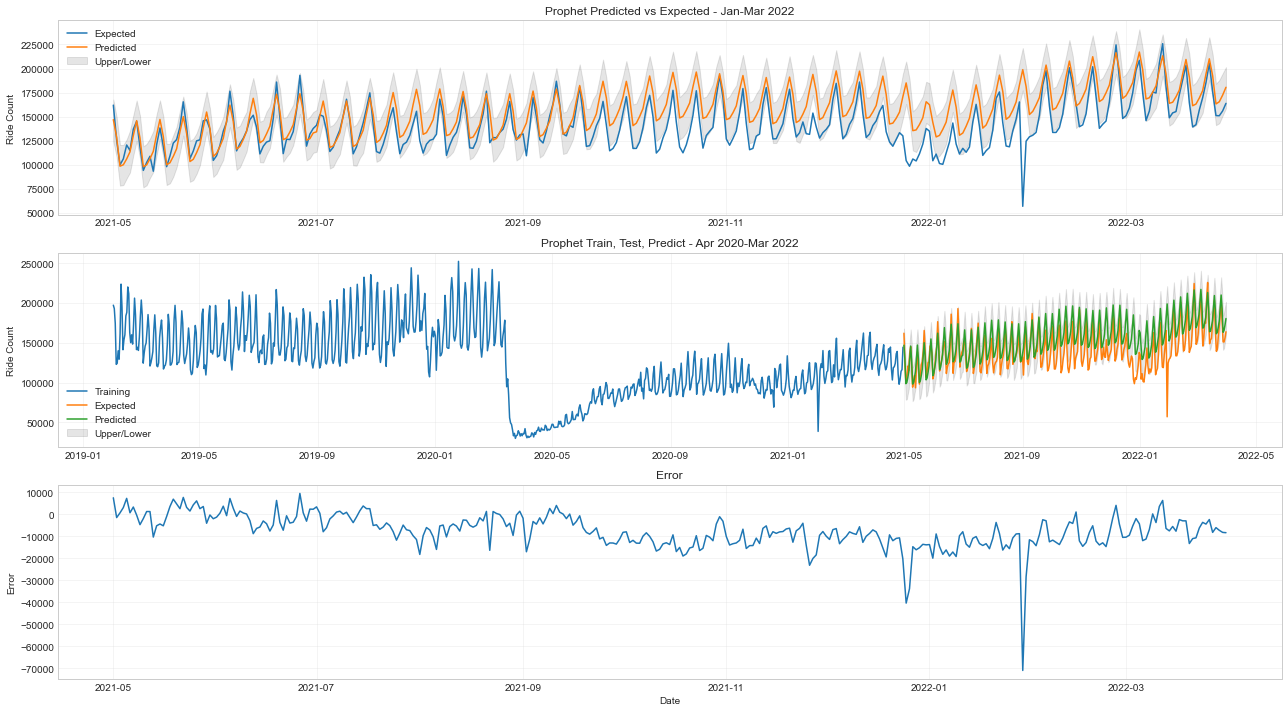

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
xgboost control     132216.42      24706.0       4357.8

In [73]:
prophet_5_train = pd.concat([prophet_train, death_train.reset_index(drop=True)], axis=1)
prophet_5_test = pd.concat([regressors, death], axis=1).reset_index(drop=True)
prophet_5_results = get_prophet(prophet_5_train, prophet_5_test, prophet_test)
get_metrics(prophet_5_results, metrics, 'prophet', 'model_5').dropna()

#### Prophet Model 6: Covid-19, Vaccinations
***

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1782.36    0.00087663       161.511           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198        1784.3   0.000127056       114.287   1.195e-06       0.001      265  LS failed, Hessian reset 
     199       1784.31   7.29314e-05       88.2788           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       1784.38   1.63242e-07       86.1805           1           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


expected      predicted        error          lower          upper
2021-05-01  162024.0  145831.931039  8096.034481  123109.575786  167904.635408
2021-05-02  125580.0  124218.585196   680.707402  103236.927939  144815.894032
2021-05-03   99954.0   96187.652628  1883.173686   74021.621515  117309.031464

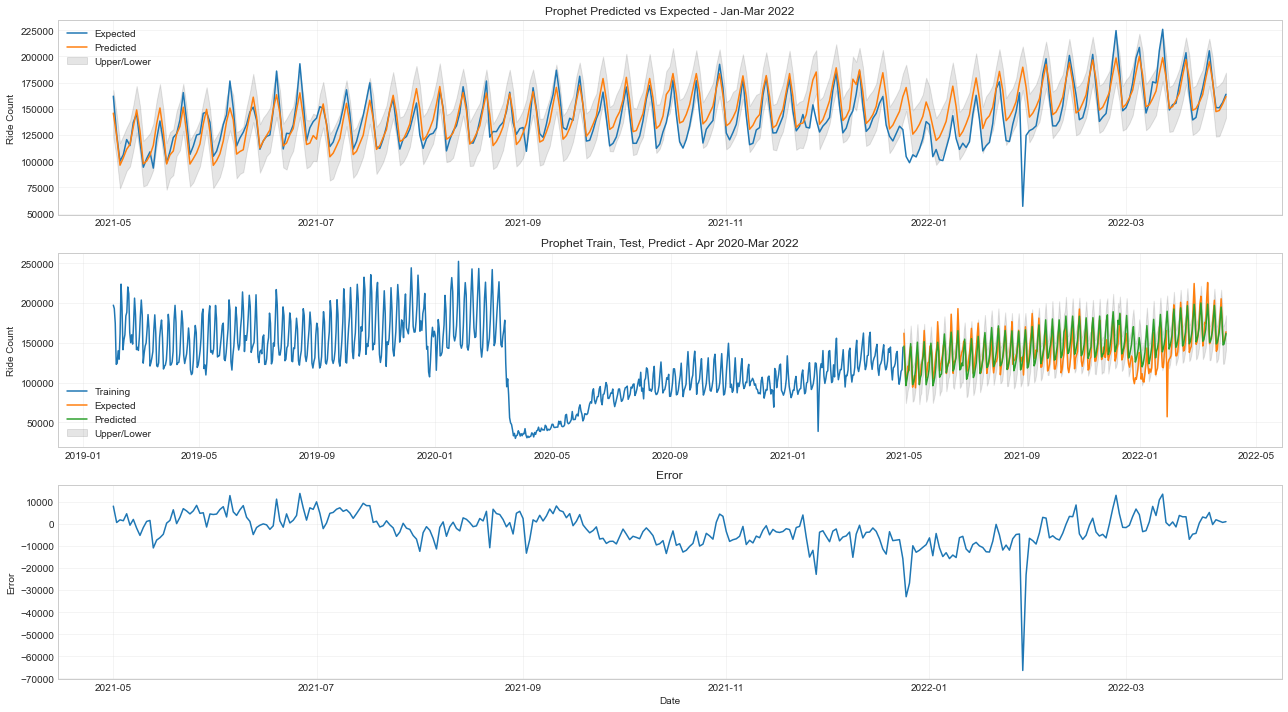

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8

In [74]:
prophet_6_train = pd.concat([prophet_train, vax_train.reset_index(drop=True)], axis=1)
prophet_6_test = pd.concat([regressors, vax], axis=1).reset_index(drop=True)
prophet_6_results = get_prophet(prophet_6_train, prophet_6_test, prophet_test)
get_metrics(prophet_6_results, metrics, 'prophet', 'model_6').dropna()

### XGBoost
***

In [75]:
temp_scaler = MinMaxScaler()
prec_scaler = MinMaxScaler()
cases_scaler = MinMaxScaler()
hosp_scaler = MinMaxScaler()
death_scaler = MinMaxScaler()
vax_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [76]:
temp_train_scaled, temp_test_scaled = split_train_test(
    pd.DataFrame(temp_scaler.fit_transform(pd.DataFrame(temp)), index=temp.index), train_stop, test_start)

prec_train_scaled, prec_test_scaled = split_train_test(
    pd.DataFrame(prec_scaler.fit_transform(pd.DataFrame(prec)), index=prec.index), train_stop, test_start)

cases_train_scaled, cases_test_scaled = split_train_test(
    pd.DataFrame(cases_scaler.fit_transform(pd.DataFrame(cases)), index=cases.index,), train_stop, test_start)

hosp_train_scaled, hosp_test_scaled = split_train_test(
    pd.DataFrame(hosp_scaler.fit_transform(pd.DataFrame(hosp)), index=hosp.index), train_stop, test_start)

death_train_scaled, death_test_scaled = split_train_test(
    pd.DataFrame(death_scaler.fit_transform(pd.DataFrame(death)), index=death.index,), train_stop, test_start)

vax_train_scaled, vax_test_scaled = split_train_test(
    pd.DataFrame(vax_scaler.fit_transform(pd.DataFrame(vax)), index=vax.index), train_stop, test_start)

y_scaler.fit(lyft)

MinMaxScaler()

In [77]:
def get_xgboost(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled):
    # Create model
    reg = xgb.XGBRegressor(n_estimators=1000)
    # Train Model
    reg.fit(X_train_scaled, y_train_scaled, 
            eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)], 
            early_stopping_rounds=50, verbose=False)
    # Plot feature importance
    _ = plot_importance(reg, height=0.9)
    plt.show()
    # Forecast
    preds = reg.predict(X_test_scaled)
    # Make results dataframe
    inverse_preds = y_scaler.inverse_transform(pd.DataFrame(preds))
    results = pd.DataFrame(y_test.values, index=y_test.index, columns=['expected'])
    results['predicted'] = pd.DataFrame(inverse_preds)[0].values
    results['error'] = xgb_results.expected - xgb_results.predicted
    # Display results
    display(results.head(3))
    # Plot results
    plot_results(results, 'XGBoost', y_train)
    plt.show()
    return results

#### XGBoost Model 1: Weather, Temp
***

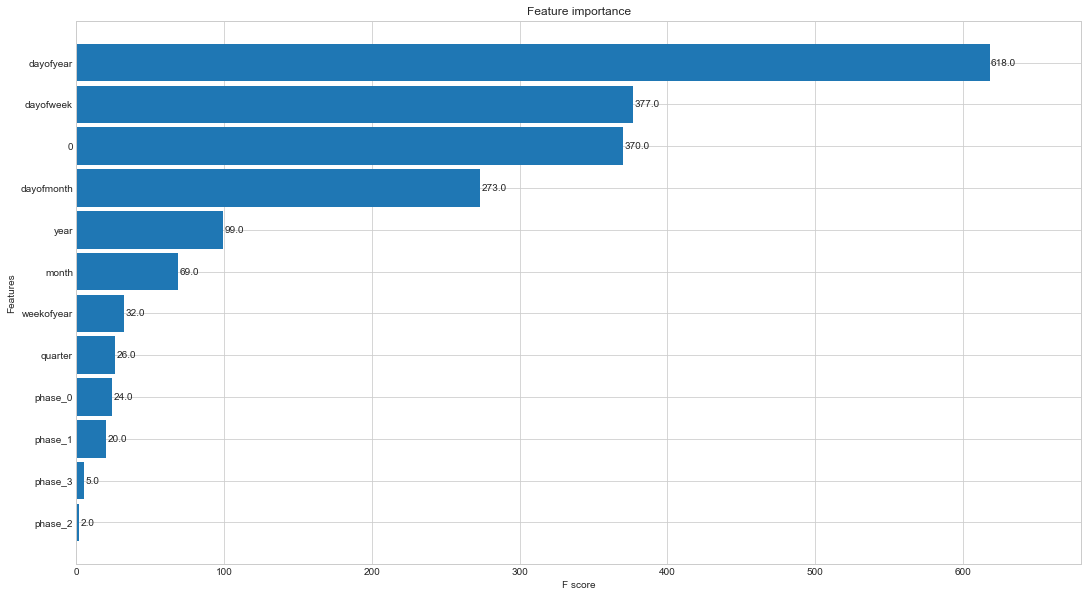

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

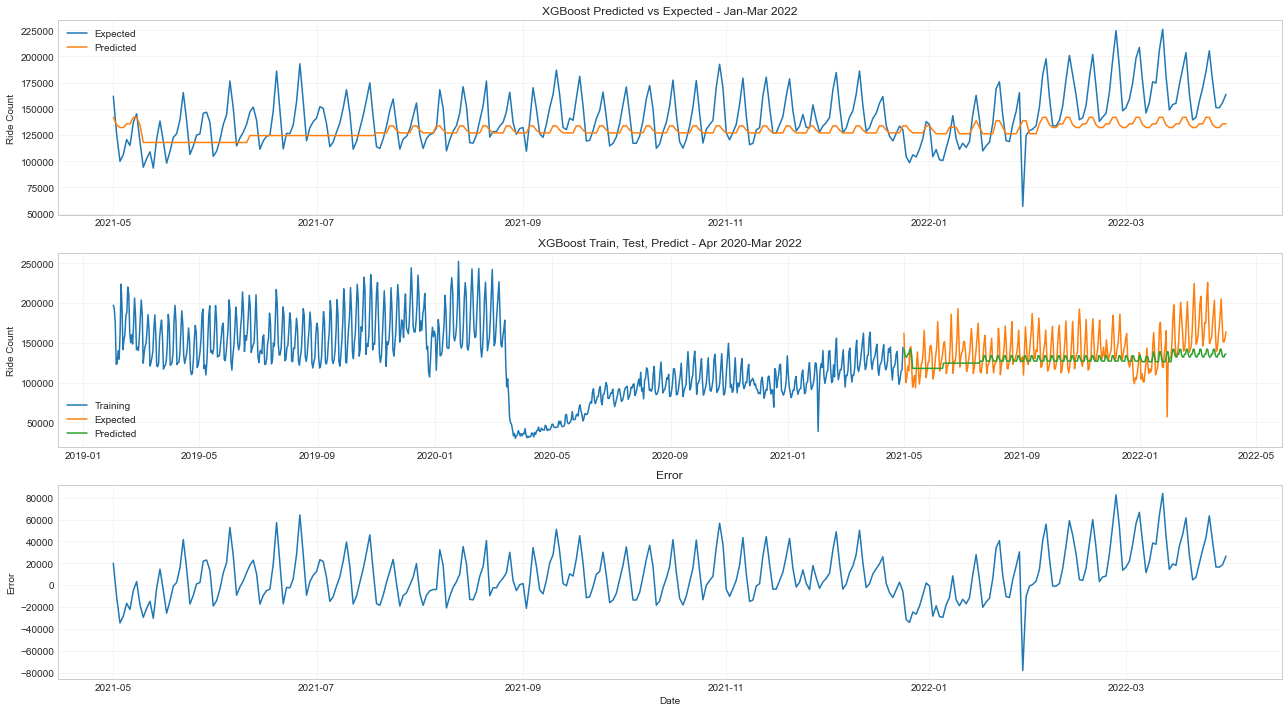

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82

In [78]:
xgb_X_train_1 = pd.concat([X_train_scaled, temp_train_scaled], axis=1)
xgb_X_test_1 = pd.concat([X_test_scaled, temp_test_scaled], axis=1)
xgb_1_results = get_xgboost(xgb_X_train_1, xgb_X_test_1, y_train_scaled, y_test_scaled)
get_metrics(xgb_1_results, metrics, 'xgboost', 'model_1').dropna()

#### XGBoost Model 2: Weather, Precipitation
***

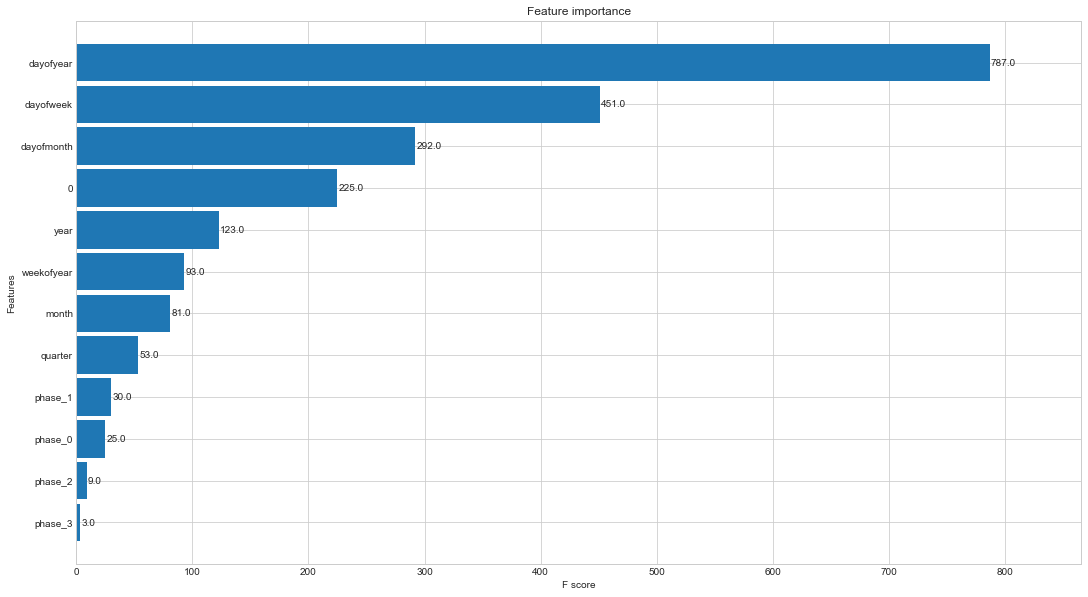

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

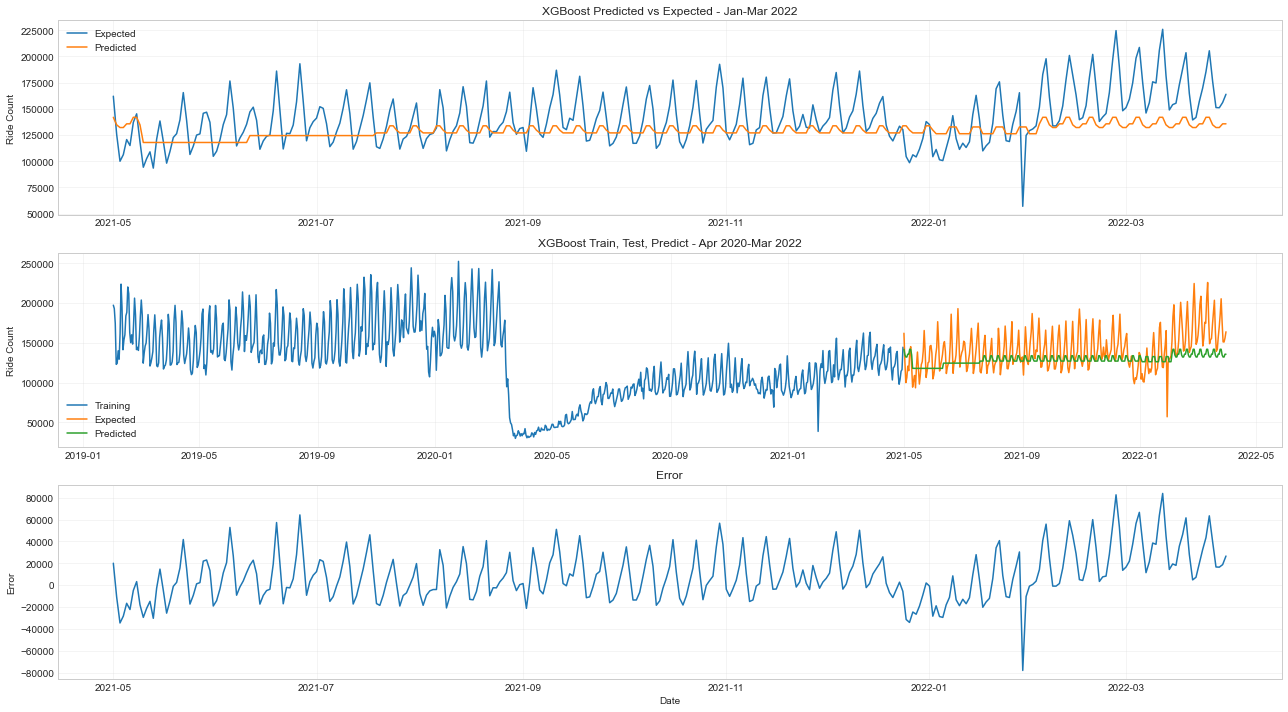

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27

In [79]:
xgb_X_train_2 = pd.concat([X_train_scaled, prec_train_scaled], axis=1)
xgb_X_test_2 = pd.concat([X_test_scaled, prec_test_scaled], axis=1)
xgb_2_results = get_xgboost(xgb_X_train_2, xgb_X_test_2, y_train_scaled, y_test_scaled)
get_metrics(xgb_2_results, metrics, 'xgboost', 'model_2').dropna()

#### XGBoost Model 3: Covid-19, Cases
***

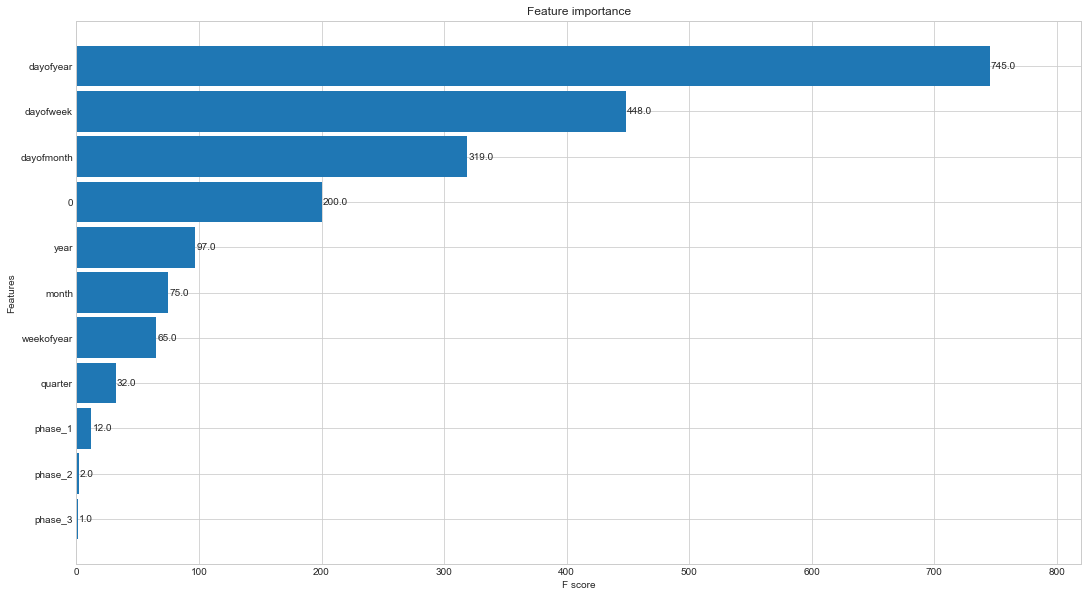

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

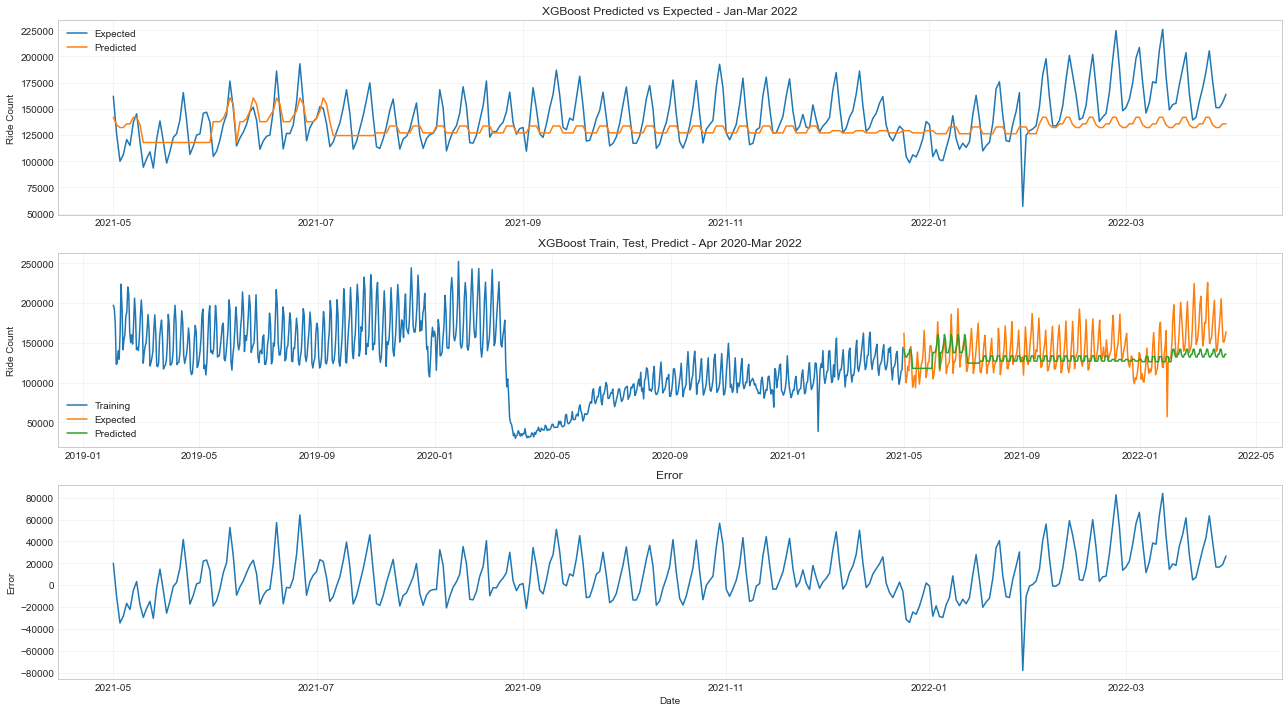

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88

In [80]:
xgb_X_train_3 = pd.concat([X_train_scaled, cases_train_scaled], axis=1)
xgb_X_test_3 = pd.concat([X_test_scaled, cases_test_scaled], axis=1)
xgb_3_results = get_xgboost(xgb_X_train_3, xgb_X_test_3, y_train_scaled, y_test_scaled)
get_metrics(xgb_3_results, metrics, 'xgboost', 'model_3').dropna()

#### XGBoost Model 4:  Covid-19, Hospitalizations

***

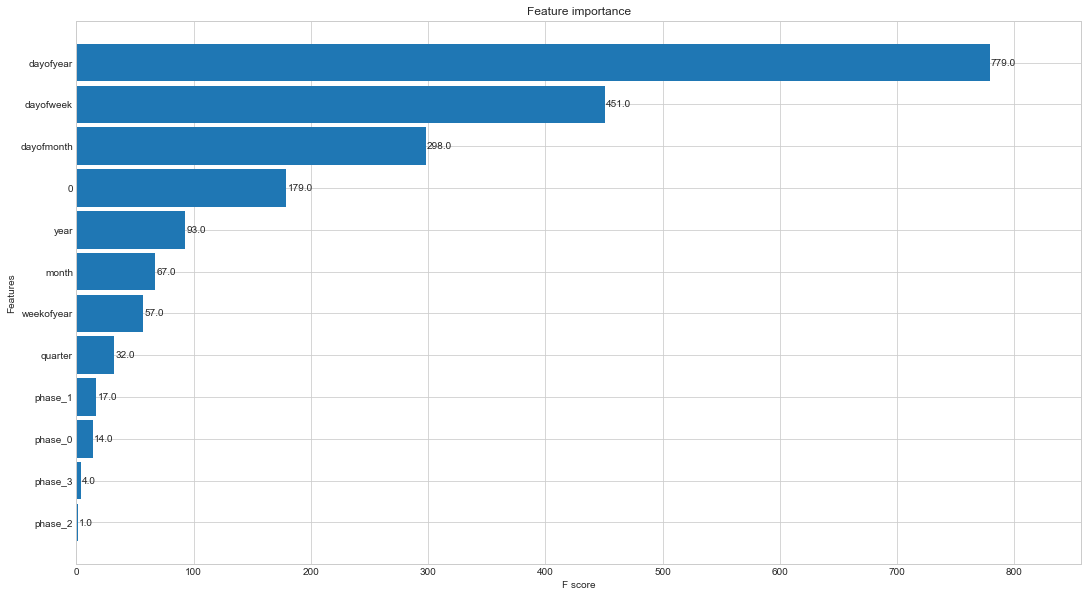

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

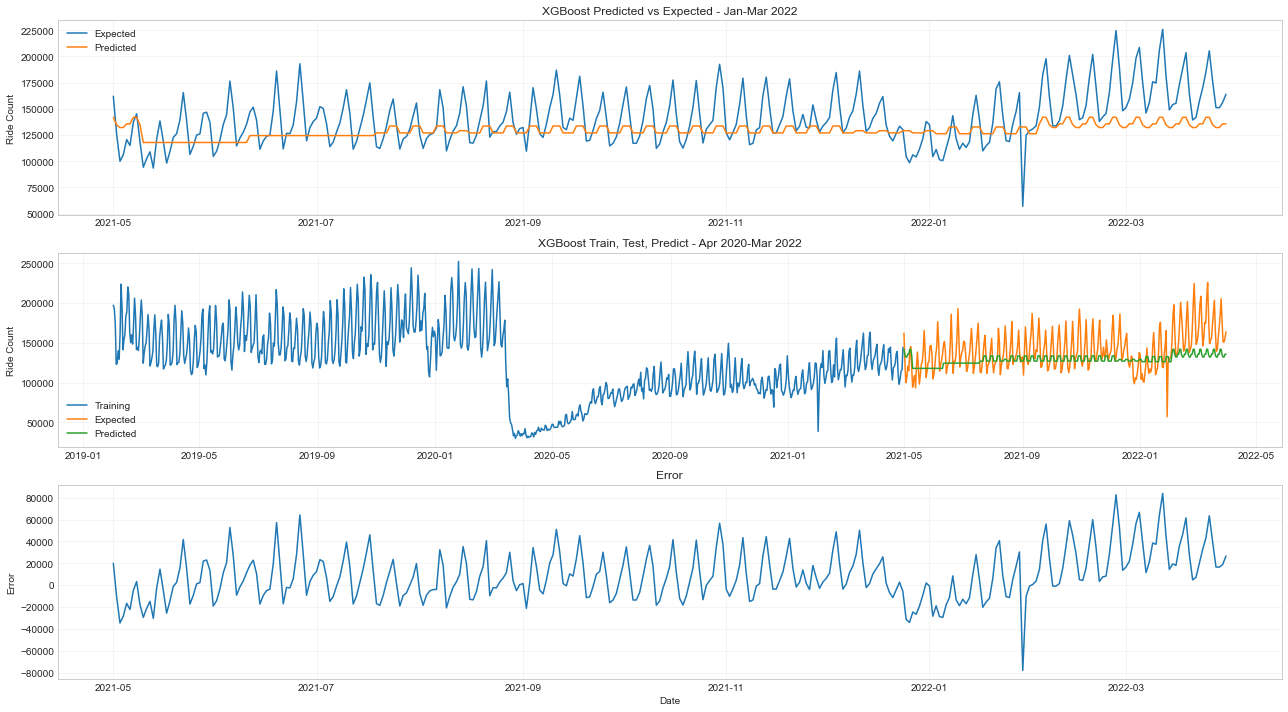

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97

In [81]:
xgb_X_train_4 = pd.concat([X_train_scaled, hosp_train_scaled], axis=1)
xgb_X_test_4 = pd.concat([X_test_scaled, hosp_test_scaled], axis=1)
xgb_4_results = get_xgboost(xgb_X_train_4, xgb_X_test_4, y_train_scaled, y_test_scaled)
get_metrics(xgb_4_results, metrics, 'xgboost', 'model_4').dropna()

#### XGBoost Model 5: Covid-19, Deaths

***

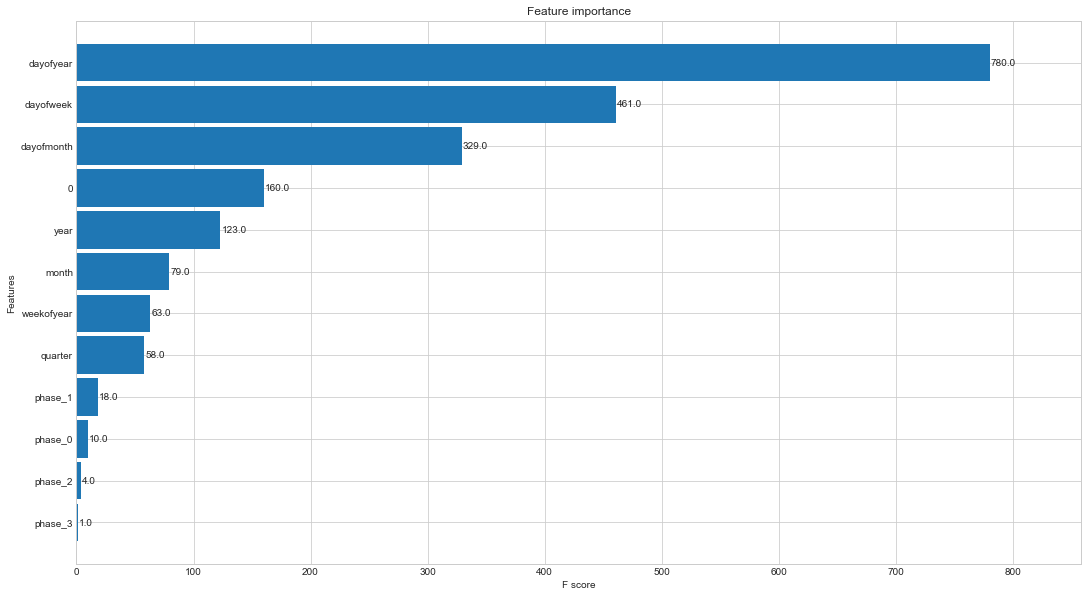

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

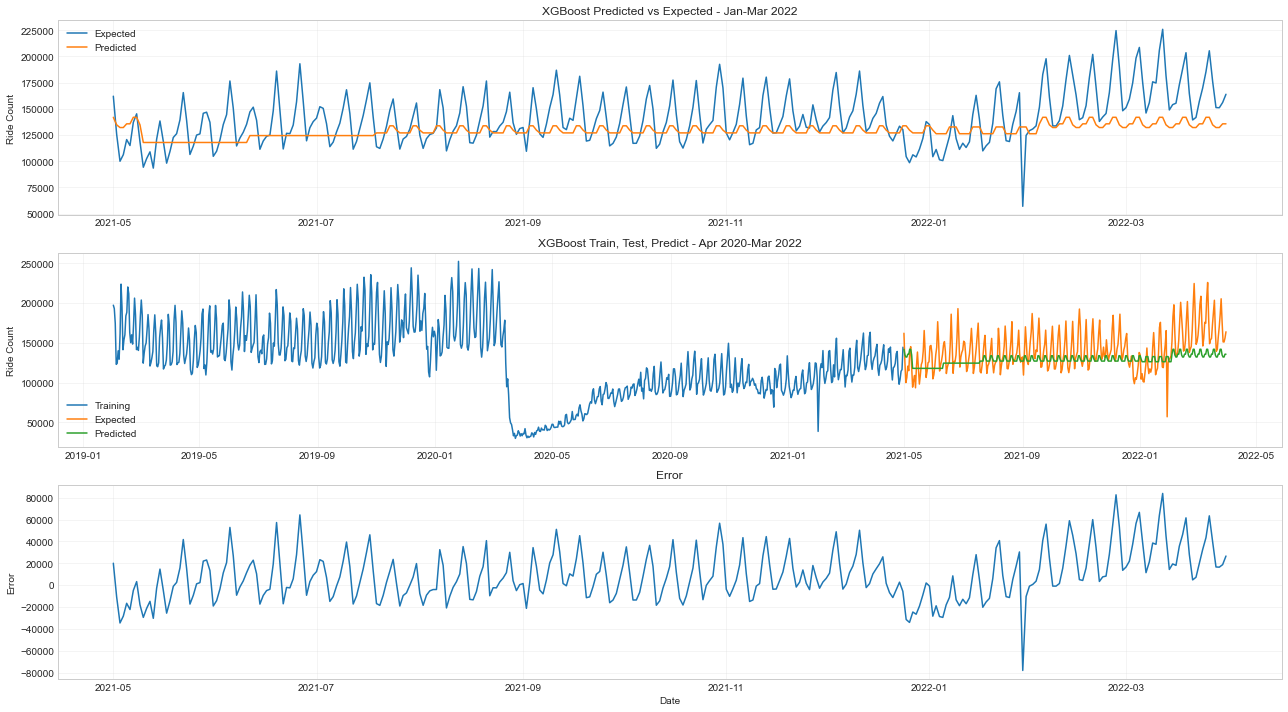

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97  
        model_5      129003.3      24706.0      5744.27

In [82]:
xgb_X_train_5 = pd.concat([X_train_scaled, death_train_scaled], axis=1)
xgb_X_test_5 = pd.concat([X_test_scaled, death_test_scaled], axis=1)
xgb_5_results = get_xgboost(xgb_X_train_5, xgb_X_test_5, y_train_scaled, y_test_scaled)
get_metrics(xgb_5_results, metrics, 'xgboost', 'model_5').dropna()

#### XGBoost Model 6: Covid-19, Vaccinations
***

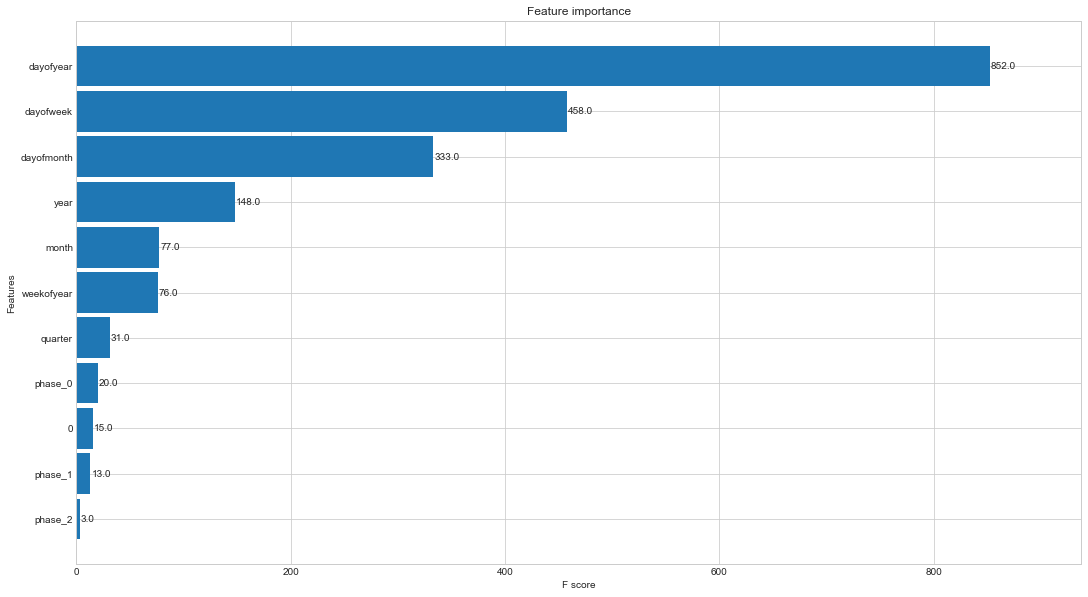

expected      predicted         error
2021-05-01  162024.0  141895.796875  20027.062500
2021-05-02  125580.0  134693.343750 -10952.890625
2021-05-03   99954.0  132124.203125 -34629.859375

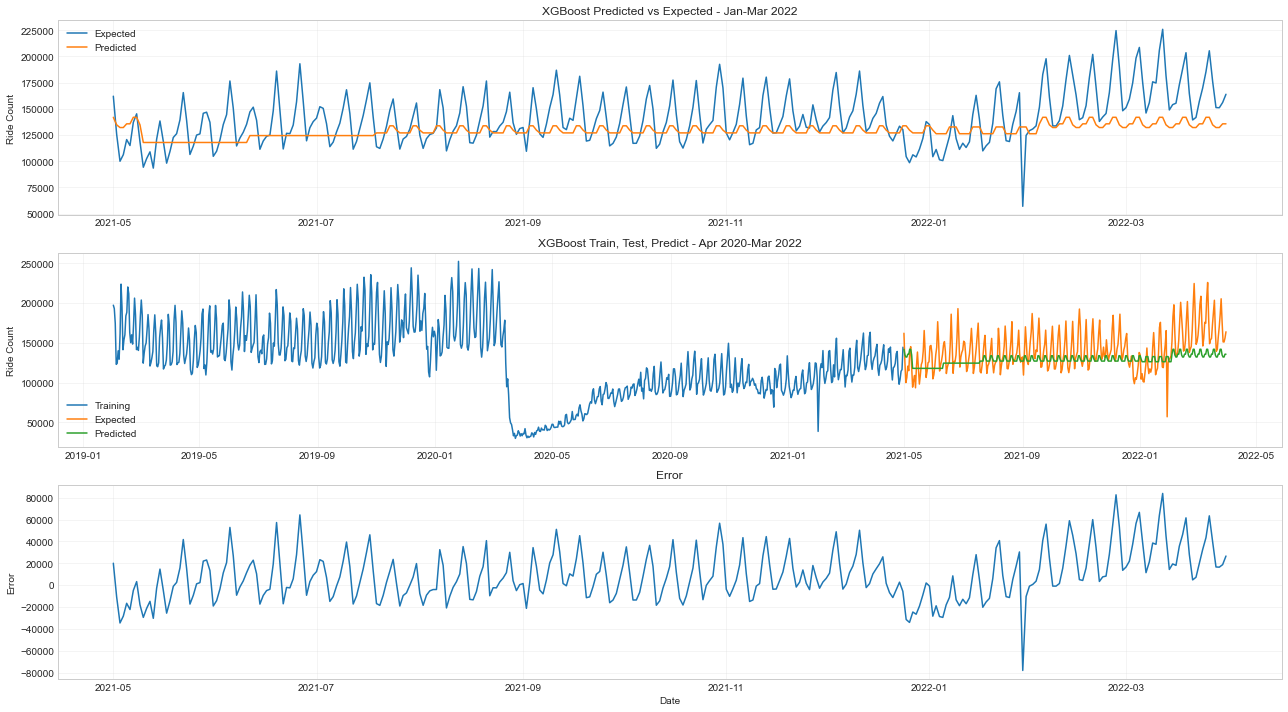

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97  
        model_5      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27

In [83]:
xgb_X_train_6 = pd.concat([X_train_scaled, vax_train_scaled], axis=1)
xgb_X_test_6 = pd.concat([X_test_scaled, vax_test_scaled], axis=1)
xgb_6_results = get_xgboost(xgb_X_train_6, xgb_X_test_6, y_train_scaled, y_test_scaled)
get_metrics(xgb_6_results, metrics, 'xgboost', 'model_6').dropna()

In [84]:
metrics.sort_values('rmse')

rmse   mape z_score    pvalue observed_mean  \
prophet model_6  15790.01   8.89  -2.598  0.009368     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
sarimax model_4  23209.42  11.68   5.877       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
sarimax model_5  23845.74  11.96   5.878       0.0     141329.33   
        control  23910.85  11.99   5.948       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
prophet model_2  24259.38  15.06  -9.996       0.0     141329.33   
sarimax model_2  24465.21  12.23   6.046       0.0     141329.33   
xgboost model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
prophet model_4   26006.5  16.16 -10.505       0.0     141329.33   
sarimax model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet model_3  77356.77   39.4    -3.1  0.001935     141329.33   
sarimax model_1  85993.42  50.06  29.409       0.0     141329.33   

                forecast_mean observed_std forecast_std  
prophet model_6     146091.02      24706.0     22612.58  
        model_5     155985.47      24706.0     24392.72  
        model_1     158279.32      24706.0     23450.48  
sarimax model_4     132468.71      24706.0     12204.38  
prophet control     159535.71      24706.0     23615.46  
sarimax model_5     132666.39      24706.0      10732.4  
        control     132563.03      24706.0     10727.75  
xgboost control     132216.42      24706.0       4357.8  
        model_3     131442.55      24706.0      7595.88  
prophet model_2     160063.82      24706.0     23721.95  
sarimax model_2     132348.92      24706.0     11250.61  
xgboost model_1     129086.51      24706.0      5842.82  
        model_4     129058.72      24706.0      5768.97  
        model_2      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27  
        model_5      129003.3      24706.0      5744.27  
prophet model_4      162345.3      24706.0     26952.93  
sarimax model_3     141064.45      24706.0     28808.88  
        model_6     109382.86      24706.0     13317.29  
prophet model_3     156500.76      24706.0     85959.12  
sarimax model_1      69883.23      24706.0     36890.12

In [85]:
metrics.loc[('prophet', 'model_7'),:] = np.nan

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1805.33   0.000762057       139.126      0.5317      0.5317      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1806.82   0.000245624       102.744           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1807.15    0.00035369       92.7408      0.2618           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1807.49    0.00010548       82.4041           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       1807.49   2.90605e-05       74.8671   3.591e-07       0.001      519  LS failed, Hessian reset 
     499       1807.56   6.97793e-05    

expected      predicted        error          lower          upper
2021-05-01  162024.0  143353.938784  9335.030608  123093.644459  163271.974605
2021-05-02  125580.0  122583.872034  1498.063983  102184.250135  144461.598514
2021-05-03   99954.0   93452.570286  3250.714857   72650.597184  114979.908875

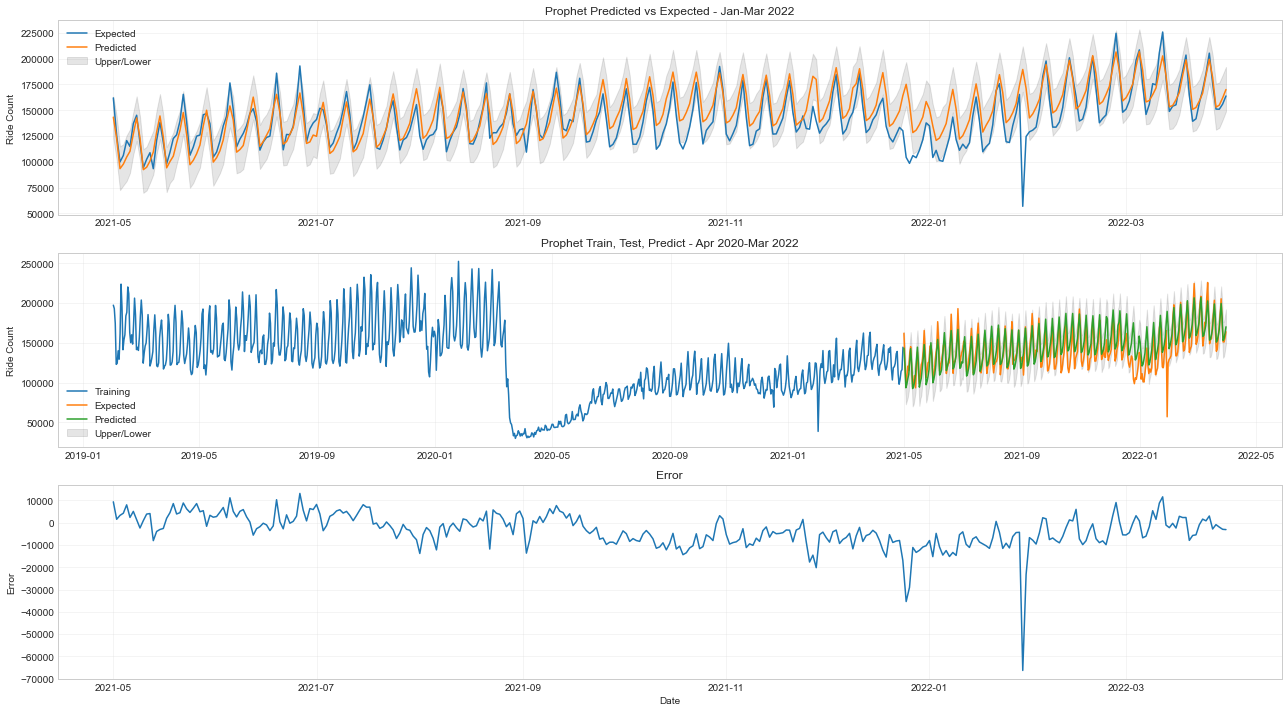

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   
prophet model_7  16351.71   9.44  -3.596  0.000323     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97  
        model_5      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27  
prophet model_7     148055.36      24706.0     23626.39

In [86]:
vax_death = pd.concat([vax, death], axis=1)
vax_death_train, vax_death_test = split_train_test(vax_death, train_stop, test_start)
prophet_7_train = pd.concat([prophet_train, vax_death_train.reset_index(drop=True)], axis=1)
prophet_7_test = pd.concat([regressors, vax_death], axis=1).reset_index(drop=True)
prophet_7_results = get_prophet(prophet_7_train, prophet_7_test, prophet_test)
get_metrics(prophet_7_results, metrics, 'prophet', 'model_7').dropna()

In [87]:
metrics.loc[('prophet', 'model_8'),:] = np.nan

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1782.35   0.000300639       131.364      0.5482      0.5482      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1784.36   0.000196598        80.255       0.805       0.805      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       1784.42   6.83783e-08       72.0557      0.2042           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


expected      predicted        error          lower          upper
2021-05-01  162024.0  148593.921016  6715.039492  126340.266552  171835.956675
2021-05-02  125580.0  127232.989715  -826.494857  104641.539112  149753.768453
2021-05-03   99954.0   99481.457695   236.271153   75025.756379  119588.540181

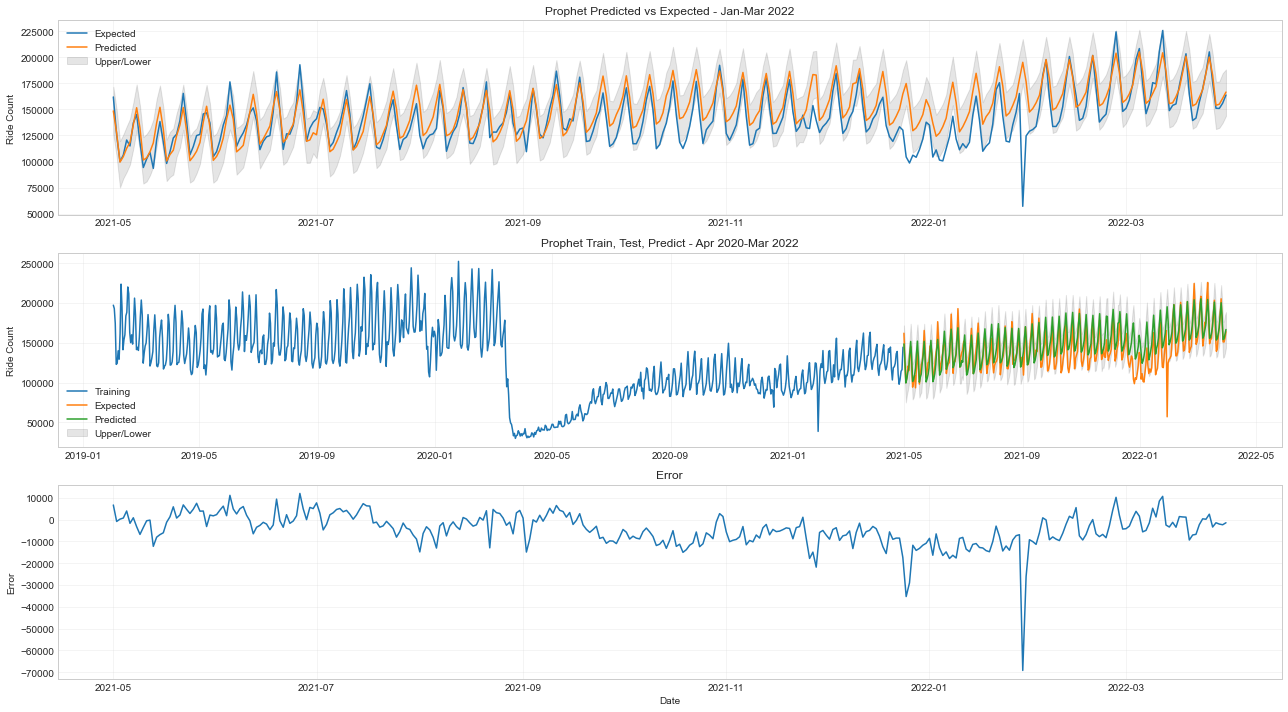

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   
prophet model_7  16351.71   9.44  -3.596  0.000323     141329.33   
        model_8  17399.55   9.99  -4.696  0.000003     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97  
        model_5      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27  
prophet model_7     148055.36      24706.0     23626.39  
        model_8     149980.15      24706.0     22874.06

In [88]:
vax_temp = pd.concat([vax, temp], axis=1)
vax_temp_train, vax_temp_test = split_train_test(vax_temp, train_stop, test_start)
prophet_8_train = pd.concat([prophet_train, vax_temp_train.reset_index(drop=True)], axis=1)
prophet_8_test = pd.concat([regressors, vax_temp], axis=1).reset_index(drop=True)
prophet_8_results = get_prophet(prophet_8_train, prophet_8_test, prophet_test)
get_metrics(prophet_8_results, metrics, 'prophet', 'model_8').dropna()

In [89]:
metrics.loc[('prophet', 'model_9'),:] = np.nan

Initial log joint probability = -24.9849
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1806.59   0.000489958        137.53      0.3751      0.3751      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1808.29   4.85925e-05       88.0995      0.3007           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1808.55   0.000170463       91.4301           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       1808.68   0.000133034       105.243   1.445e-06       0.001      435  LS failed, Hessian reset 
     399       1808.76   9.92582e-05       82.0621           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456       1808.83   8.66854e-06    

expected      predicted        error          lower          upper
2021-05-01  162024.0  143992.112191  9015.943905  124412.457332  164899.259166
2021-05-02  125580.0  121269.306431  2155.346785  100258.683156  142530.751927
2021-05-03   99954.0   93540.045240  3206.977380   71040.994197  113325.474505

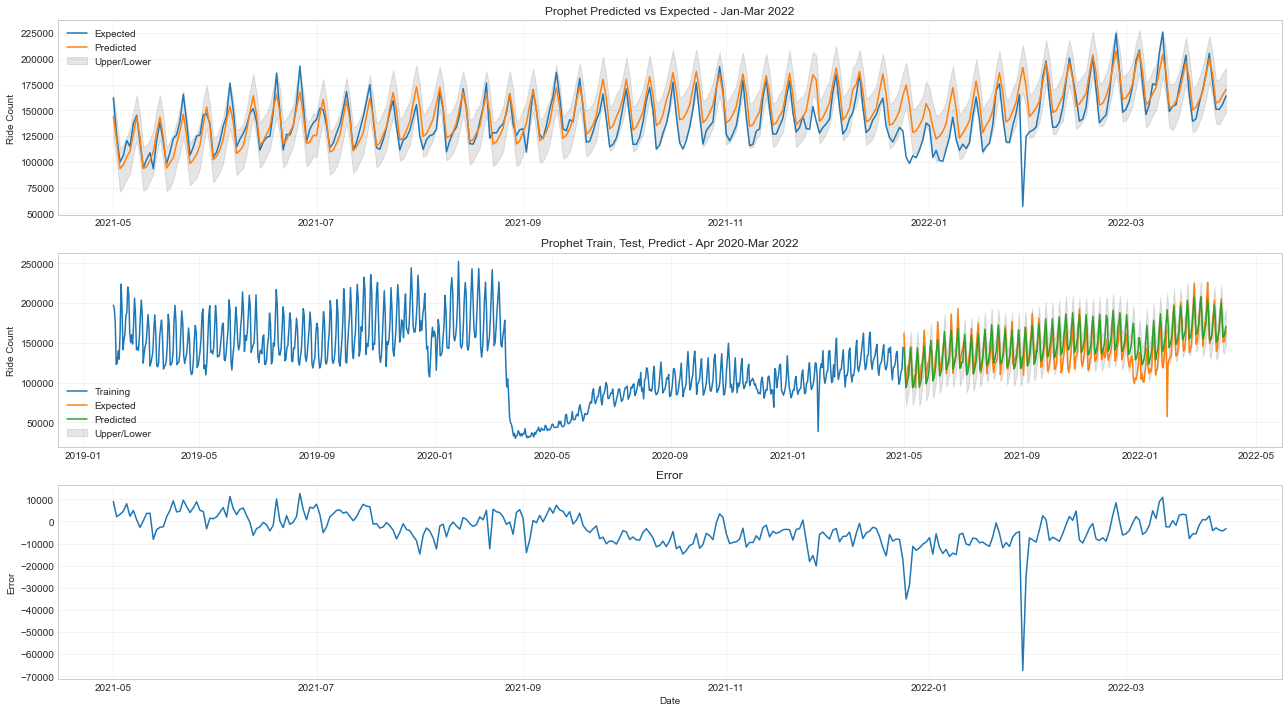

rmse   mape z_score    pvalue observed_mean  \
sarimax control  23910.85  11.99   5.948       0.0     141329.33   
        model_1  85993.42  50.06  29.409       0.0     141329.33   
        model_2  24465.21  12.23   6.046       0.0     141329.33   
        model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_4  23209.42  11.68   5.877       0.0     141329.33   
        model_5  23845.74  11.96   5.878       0.0     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
        model_2  24259.38  15.06  -9.996       0.0     141329.33   
        model_3  77356.77   39.4    -3.1  0.001935     141329.33   
        model_4   26006.5  16.16 -10.505       0.0     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_6  15790.01   8.89  -2.598  0.009368     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   
prophet model_7  16351.71   9.44  -3.596  0.000323     141329.33   
        model_8  17399.55   9.99  -4.696  0.000003     141329.33   
        model_9  16474.47   9.52   -3.76   0.00017     141329.33   

                forecast_mean observed_std forecast_std  
sarimax control     132563.03      24706.0     10727.75  
        model_1      69883.23      24706.0     36890.12  
        model_2     132348.92      24706.0     11250.61  
        model_3     141064.45      24706.0     28808.88  
        model_4     132468.71      24706.0     12204.38  
        model_5     132666.39      24706.0      10732.4  
        model_6     109382.86      24706.0     13317.29  
prophet control     159535.71      24706.0     23615.46  
        model_1     158279.32      24706.0     23450.48  
        model_2     160063.82      24706.0     23721.95  
        model_3     156500.76      24706.0     85959.12  
        model_4      162345.3      24706.0     26952.93  
        model_5     155985.47      24706.0     24392.72  
        model_6     146091.02      24706.0     22612.58  
xgboost control     132216.42      24706.0       4357.8  
        model_1     129086.51      24706.0      5842.82  
        model_2      129003.3      24706.0      5744.27  
        model_3     131442.55      24706.0      7595.88  
        model_4     129058.72      24706.0      5768.97  
        model_5      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27  
prophet model_7     148055.36      24706.0     23626.39  
        model_8     149980.15      24706.0     22874.06  
        model_9     148355.88      24706.0      23577.6

In [90]:
vax_death_temp = pd.concat([vax_death, temp], axis=1)
vax_death_temp_train, vax_death_temp_test = split_train_test(vax_death_temp, train_stop, test_start)
prophet_9_train = pd.concat([prophet_train, vax_death_temp_train.reset_index(drop=True)], axis=1)
prophet_9_test = pd.concat([regressors, vax_death_temp], axis=1).reset_index(drop=True)
prophet_9_results = get_prophet(prophet_9_train, prophet_9_test, prophet_test)
get_metrics(prophet_9_results, metrics, 'prophet', 'model_9').dropna()

>**Research Question 4:**
>
>What is the forecasted growth of rideshare demand for each company?
***

In [91]:
metrics.sort_values('rmse')

rmse   mape z_score    pvalue observed_mean  \
prophet model_6  15790.01   8.89  -2.598  0.009368     141329.33   
        model_7  16351.71   9.44  -3.596  0.000323     141329.33   
        model_9  16474.47   9.52   -3.76   0.00017     141329.33   
        model_8  17399.55   9.99  -4.696  0.000003     141329.33   
        model_5  21178.04  12.77  -7.715       0.0     141329.33   
        model_1  22778.34  13.96  -9.094       0.0     141329.33   
sarimax model_4  23209.42  11.68   5.877       0.0     141329.33   
prophet control  23773.53  14.73  -9.736       0.0     141329.33   
sarimax model_5  23845.74  11.96   5.878       0.0     141329.33   
        control  23910.85  11.99   5.948       0.0     141329.33   
xgboost control  24091.72  12.38   6.639       0.0     141329.33   
        model_3  24151.31  12.32    6.99       0.0     141329.33   
prophet model_2  24259.38  15.06  -9.996       0.0     141329.33   
sarimax model_2  24465.21  12.23   6.046       0.0     141329.33   
xgboost model_1  24919.95  12.66   8.813       0.0     141329.33   
        model_4  24923.99  12.59   8.839       0.0     141329.33   
        model_2  24925.84  12.65   8.881       0.0     141329.33   
        model_5  24925.84  12.65   8.881       0.0     141329.33   
        model_6  24925.84  12.65   8.881       0.0     141329.33   
prophet model_4   26006.5  16.16 -10.505       0.0     141329.33   
sarimax model_3   39889.4  18.73   0.128  0.898505     141329.33   
        model_6   40446.7  22.61  20.802       0.0     141329.33   
prophet model_3  77356.77   39.4    -3.1  0.001935     141329.33   
sarimax model_1  85993.42  50.06  29.409       0.0     141329.33   

                forecast_mean observed_std forecast_std  
prophet model_6     146091.02      24706.0     22612.58  
        model_7     148055.36      24706.0     23626.39  
        model_9     148355.88      24706.0      23577.6  
        model_8     149980.15      24706.0     22874.06  
        model_5     155985.47      24706.0     24392.72  
        model_1     158279.32      24706.0     23450.48  
sarimax model_4     132468.71      24706.0     12204.38  
prophet control     159535.71      24706.0     23615.46  
sarimax model_5     132666.39      24706.0      10732.4  
        control     132563.03      24706.0     10727.75  
xgboost control     132216.42      24706.0       4357.8  
        model_3     131442.55      24706.0      7595.88  
prophet model_2     160063.82      24706.0     23721.95  
sarimax model_2     132348.92      24706.0     11250.61  
xgboost model_1     129086.51      24706.0      5842.82  
        model_4     129058.72      24706.0      5768.97  
        model_2      129003.3      24706.0      5744.27  
        model_5      129003.3      24706.0      5744.27  
        model_6      129003.3      24706.0      5744.27  
prophet model_4      162345.3      24706.0     26952.93  
sarimax model_3     141064.45      24706.0     28808.88  
        model_6     109382.86      24706.0     13317.29  
prophet model_3     156500.76      24706.0     85959.12  
sarimax model_1      69883.23      24706.0     36890.12

## Forecast Demand
***

In [92]:
def get_pred(info, regs=False, regressors=None, conf_int=False):
    train, future = (info)
    m= Prophet(daily_seasonality=7)
    if regs == True:
        for col in regressors.columns:
            m.add_regressor(col)
    m.fit(train)
    fcast = m.predict(future)
    if conf_int == True:
        fcast = fcast[
            ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
        ].set_index('ds')
    else:
        fcast = fcast[['ds', 'yhat']].set_index('ds')
    return fcast

In [93]:
observed_data = pd.DataFrame(index = np.arange(np.datetime64('2019-02-01'), np.datetime64('2022-07-01')))

In [94]:
lyft_data = pd.concat([observed_data, lyft], axis=1)

In [95]:
lyft_X, lyft_y = get_Xy_features(lyft_data)

In [96]:
lyft_X.phase_0.fillna(0, inplace=True)
lyft_X.phase_1.fillna(0, inplace=True)
lyft_X.phase_2.fillna(0, inplace=True)
lyft_X.phase_3.fillna(1, inplace=True)

In [97]:
lyft_X.holiday[['2022/05/30', '2022/06/19', '2022/06/20']] = 1

### Forecast Vaccinations
***

In [98]:
vax_y = pd.concat([observed_data, vax], axis=1)

In [99]:
vax_y

vaccination
2019-02-01          0.0
2019-02-02          0.0
2019-02-03          0.0
2019-02-04          0.0
2019-02-05          0.0
...                 ...
2022-06-26          NaN
2022-06-27          NaN
2022-06-28          NaN
2022-06-29          NaN
2022-06-30          NaN

[1246 rows x 1 columns]

In [100]:
def get_prophet_df(df):
    prophet_df = df.reset_index()
    prophet_df.columns = ['ds', 'y']
    return prophet_df

In [101]:
prophet_vax = get_prophet_df(vax_y)

In [102]:
prophet_vax.head(3)

ds    y
0 2019-02-01  0.0
1 2019-02-02  0.0
2 2019-02-03  0.0

In [103]:
stop, start = '2022/03/31', '2022/04/01'

In [104]:
prophet_vax_train = prophet_vax.loc[:prophet_vax[prophet_vax.ds == stop].index.values[0]]

In [105]:
vax_preds = get_pred((prophet_vax_train, prophet_vax))

Initial log joint probability = -10.3727
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2339.7     0.0111116       188.608           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       2350.34   0.000132732       118.298   6.687e-07       0.001      296  LS failed, Hessian reset 
     199       2350.35   6.78392e-05       111.714           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2352.33    0.00338496       109.216           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       2353.28   0.000134826       131.262   1.311e-06       0.001      491  LS failed, Hessian reset 
     399       2356.45    0.00733439       103.291      0.2382           1      599   
    Iter      log pro

In [106]:
vax_preds[:stop] = vax_y[:stop]

In [107]:
vax_preds.columns = ['vaccinations']

In [108]:
vax_preds

vaccinations
ds                      
2019-02-01      0.000000
2019-02-02      0.000000
2019-02-03      0.000000
2019-02-04      0.000000
2019-02-05      0.000000
...                  ...
2022-06-26   9397.147475
2022-06-27   8782.678348
2022-06-28  10963.442706
2022-06-29  11153.121997
2022-06-30  12594.693327

[1246 rows x 1 columns]

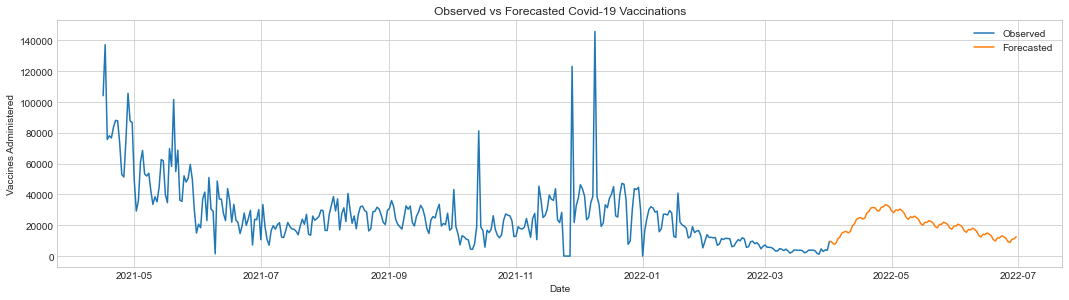

In [109]:
plt.subplot(211)
plt.plot(vax_preds['2021/04/16':'2022/04/01'], label='Observed')
plt.plot(vax_preds['2022/04/01':], label='Forecasted')
plt.title('Observed vs Forecasted Covid-19 Vaccinations')
plt.xlabel('Date')
plt.ylabel('Vaccines Administered')
plt.legend()
plt.show()

### Forecast Rideshare Demand
***

In [110]:
prophet_df = get_prophet_df(lyft_y)

In [111]:
prophet_exog = pd.concat([lyft_X, vax_preds], axis=1)

In [112]:
prophet_df = pd.concat([prophet_df, prophet_exog.reset_index(drop=True)], axis=1)

In [113]:
prophet_df.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2019-02-01  197336.0          4        1      2  2019         32   
1 2019-02-02  193081.0          5        1      2  2019         33   
2 2019-02-03  174515.0          6        1      2  2019         34   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  \
0           1           5      1.0      0.0      0.0      0.0        0   
1           2           5      1.0      0.0      0.0      0.0        0   
2           3           5      1.0      0.0      0.0      0.0        0   

   vaccinations  
0           0.0  
1           0.0  
2           0.0

In [114]:
train = prophet_df.loc[:prophet_df[prophet_df.ds == stop].index.values[0]]
test = prophet_df

In [115]:
results = get_pred((train, test), regs=True, regressors=prophet_exog, conf_int=True)

Initial log joint probability = -39.3961
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2586.39    0.00464189        156.53           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2587.55   2.24939e-06       58.2744      0.4505      0.4505      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2587.91   0.000176601       84.4559           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       2587.97   0.000206336       106.826   2.186e-06       0.001      493  LS failed, Hessian reset 
     399          2588   3.54925e-05       73.9709           1           1      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2588.04    1.0242e-05    

In [116]:
results = np.round(pd.concat([results, test[['ds', 'vaccinations']].set_index('ds', drop=True)], axis=1), 2)

In [117]:
results

yhat  yhat_lower  yhat_upper  vaccinations
ds                                                         
2019-02-01  163365.96   141195.55   184800.55          0.00
2019-02-02  179403.51   159739.28   201214.69          0.00
2019-02-03  159786.71   140250.34   179211.52          0.00
2019-02-04  131896.26   111965.17   152196.90          0.00
2019-02-05  134278.76   113288.97   155632.09          0.00
...               ...         ...         ...           ...
2022-06-26  177499.57   156957.03   195990.29       9397.15
2022-06-27  149114.46   129489.86   169660.47       8782.68
2022-06-28  151135.74   130047.74   172452.90      10963.44
2022-06-29  157637.43   136052.53   177662.77      11153.12
2022-06-30  164990.79   145396.64   185800.18      12594.69

[1246 rows x 4 columns]

In [118]:
z_test = ztest(y, results.yhat['2022/04/01':])
metrics.loc[('forecast', 'forecast'),:] = np.round([
    np.nan,
    np.nan,
    z_test[0][0],
    z_test[1][0],
    y.lyft.mean(),
    results.yhat.mean(),
    np.std(y.lyft),
    np.std(results.yhat)
], 2)

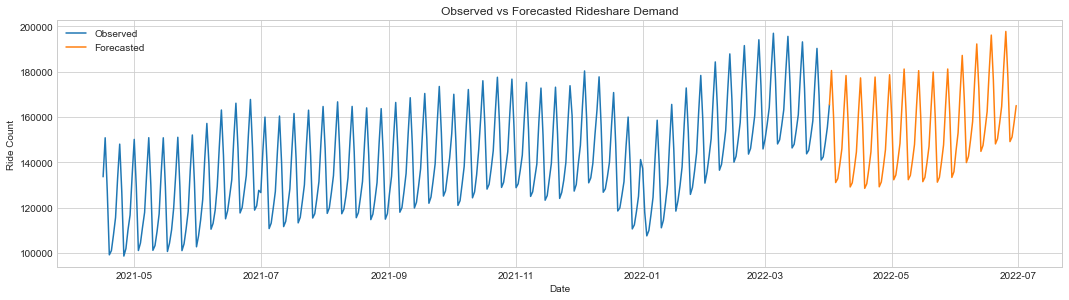

In [119]:
plt.subplot(211)
plt.plot(results.yhat['2021/04/16':'2022/04/01'], label='Observed')
plt.plot(results.yhat['2022/04/01':], label='Forecasted')
plt.title('Observed vs Forecasted Rideshare Demand')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.show()

In [120]:
metrics

rmse   mape z_score    pvalue observed_mean  \
sarimax  control   23910.85  11.99   5.948       0.0     141329.33   
         model_1   85993.42  50.06  29.409       0.0     141329.33   
         model_2   24465.21  12.23   6.046       0.0     141329.33   
         model_3    39889.4  18.73   0.128  0.898505     141329.33   
         model_4   23209.42  11.68   5.877       0.0     141329.33   
         model_5   23845.74  11.96   5.878       0.0     141329.33   
         model_6    40446.7  22.61  20.802       0.0     141329.33   
prophet  control   23773.53  14.73  -9.736       0.0     141329.33   
         model_1   22778.34  13.96  -9.094       0.0     141329.33   
         model_2   24259.38  15.06  -9.996       0.0     141329.33   
         model_3   77356.77   39.4    -3.1  0.001935     141329.33   
         model_4    26006.5  16.16 -10.505       0.0     141329.33   
         model_5   21178.04  12.77  -7.715       0.0     141329.33   
         model_6   15790.01   8.89  -2.598  0.009368     141329.33   
xgboost  control   24091.72  12.38   6.639       0.0     141329.33   
         model_1   24919.95  12.66   8.813       0.0     141329.33   
         model_2   24925.84  12.65   8.881       0.0     141329.33   
         model_3   24151.31  12.32    6.99       0.0     141329.33   
         model_4   24923.99  12.59   8.839       0.0     141329.33   
         model_5   24925.84  12.65   8.881       0.0     141329.33   
         model_6   24925.84  12.65   8.881       0.0     141329.33   
prophet  model_7   16351.71   9.44  -3.596  0.000323     141329.33   
         model_8   17399.55   9.99  -4.696  0.000003     141329.33   
         model_9   16474.47   9.52   -3.76   0.00017     141329.33   
forecast forecast       NaN    NaN   -5.33       0.0     131524.86   

                  forecast_mean observed_std forecast_std  
sarimax  control      132563.03      24706.0     10727.75  
         model_1       69883.23      24706.0     36890.12  
         model_2      132348.92      24706.0     11250.61  
         model_3      141064.45      24706.0     28808.88  
         model_4      132468.71      24706.0     12204.38  
         model_5      132666.39      24706.0      10732.4  
         model_6      109382.86      24706.0     13317.29  
prophet  control      159535.71      24706.0     23615.46  
         model_1      158279.32      24706.0     23450.48  
         model_2      160063.82      24706.0     23721.95  
         model_3      156500.76      24706.0     85959.12  
         model_4       162345.3      24706.0     26952.93  
         model_5      155985.47      24706.0     24392.72  
         model_6      146091.02      24706.0     22612.58  
xgboost  control      132216.42      24706.0       4357.8  
         model_1      129086.51      24706.0      5842.82  
         model_2       129003.3      24706.0      5744.27  
         model_3      131442.55      24706.0      7595.88  
         model_4      129058.72      24706.0      5768.97  
         model_5       129003.3      24706.0      5744.27  
         model_6       129003.3      24706.0      5744.27  
prophet  model_7      148055.36      24706.0     23626.39  
         model_8      149980.15      24706.0     22874.06  
         model_9      148355.88      24706.0      23577.6  
forecast forecast     133236.66     41571.46     37635.94

In [121]:
results.to_parquet('data/lyft_forecast.parquet')

In [122]:
metrics.to_parquet('data/lyft_model_metrics.parquet')